In [1]:
import numpy as np
import time
import argparse
import pickle
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse import coo_matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import sys
import logging
import numpy as np


def get_logger(filename):
    # Logging configuration: set the basic configuration of the logging system
    log_formatter = logging.Formatter(fmt='%(asctime)s [%(processName)s, %(process)s] [%(levelname)-5.5s]  %(message)s',
                                      datefmt='%m-%d %H:%M')
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    # File logger
    file_handler = logging.FileHandler("{}.log".format(filename))
    file_handler.setFormatter(log_formatter)
    file_handler.setLevel(logging.DEBUG)
    logger.addHandler(file_handler)
    # Stderr logger
    std_handler = logging.StreamHandler(sys.stdout)
    std_handler.setFormatter(log_formatter)
    std_handler.setLevel(logging.DEBUG)
    logger.addHandler(std_handler)
    return logger


def data_loader(inputs, targets, batch_size, shuffle=True):
    assert inputs.shape[0] == targets.shape[0]
    inputs_size = inputs.shape[0]
    if shuffle:
        random_order = np.arange(inputs_size)
        np.random.shuffle(random_order)
        inputs, targets = inputs[random_order, :], targets[random_order]
    num_blocks = int(inputs_size / batch_size)
    for i in range(num_blocks):
        yield inputs[i * batch_size: (i+1) * batch_size, :], targets[i * batch_size: (i+1) * batch_size]
    if num_blocks * batch_size != inputs_size:
        yield inputs[num_blocks * batch_size:, :], targets[num_blocks * batch_size:]


def multi_data_loader(inputs, targets, batch_size, shuffle=True):
    """
    Both inputs and targets are list of numpy arrays, containing instances and labels from multiple sources.
    """
    assert len(inputs) == len(targets)
    input_sizes = [data.shape[0] for data in inputs]
    max_input_size = max(input_sizes)
    num_domains = len(inputs)
    if shuffle:
        for i in range(num_domains):
            r_order = np.arange(input_sizes[i])
            np.random.shuffle(r_order)
            inputs[i], targets[i] = inputs[i][r_order, :], targets[i][r_order]
    num_blocks = int(max_input_size / batch_size)
    for j in range(num_blocks):
        xs, ys = [], []
        for i in range(num_domains):
            ridx = np.random.choice(input_sizes[i], batch_size)
            xs.append(inputs[i][ridx, :])
            ys.append(targets[i][ridx])
        yield xs, ys

True
Sun Sep  4 16:30:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 32%   55C    P2    44W / 180W |   2789MiB /  8192MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [16]:
torch. __version__

'1.10.0+cu113'

In [2]:
from sklearn.metrics import  zero_one_loss,mean_absolute_error,r2_score, mean_squared_error
from math import sqrt
def get_mae(target, prediction):
    assert (target.shape == prediction.shape)

    return mean_absolute_error(target, prediction)

def get_mse(target, prediction):
    assert (target.shape == prediction.shape)

    return mean_squared_error(target, prediction)

def get_sae(target, prediction):
    assert (target.shape == prediction.shape)

    r = target.sum()
    r0 = prediction.sum()
    sae = abs(r0 - r) / r
    return sae

def get_nde(target, prediction):
    assert (target.shape == prediction.shape)

    error, squarey = [], []
    for i in range(len(prediction)):
        value = prediction[i] - target[i]
        error.append(value * value)
        squarey.append(target[i] * target[i])
    nde = sqrt(sum(error) / sum(squarey))
    return nde


In [3]:
#####################################################Regression#######################################
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
def dataProvider(file,windowsize,stepsize,threshold):  
    dataframe=pd.read_csv(file,header=0)    
    np_array=np.array(dataframe)
    inputs, targets=np_array[:, 0], np_array[:, 1]
    offset = int(0.5 * (windowsize - 1.0))
#     window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    i=0
    while (i<=inputs.size-windowsize):
        data_in=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(data_in)
        labels.append(tar)
        i=i+stepsize
    X=np.array(features)
    Y=np.array(labels)
    Y[Y<=threshold] = 0
    # scaler = MinMaxScaler()
    # X=scaler.fit_transform(X)
    x_train_all, X, y_train_all, Y = train_test_split(X, Y, test_size=0.2,random_state=100)
    return X,Y

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

def EntropyLoss(input_):
    mask = input_.ge(0.000001)
    mask_out = torch.masked_select(input_, mask)
    entropy = -(torch.sum(mask_out * torch.log(mask_out)))
    return entropy / float(input_.size(0))

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)

    
def JAN(source_list, target_list, kernel_muls=[2.0, 2.0], kernel_nums=[1, 1], fix_sigma_list=[None, 1.68]):
    batch_size = int(source_list[0].size()[0])
    layer_num = len(source_list)
    joint_kernels = None
    for i in range(layer_num):
        source = source_list[i]
        target = target_list[i]
        kernel_mul = kernel_muls[i]
        kernel_num = kernel_nums[i]
        fix_sigma = fix_sigma_list[i]
        kernels = guassian_kernel(source, target,
            kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        if i==0:
            joint_kernels=torch.ones_like(kernels)
        if joint_kernels is not None:
            joint_kernels = joint_kernels * kernels
        else:
            joint_kernels = kernels

    loss1 = 0
    for s1 in range(batch_size):
        for s2 in range(s1 + 1, batch_size):
            t1, t2 = s1 + batch_size, s2 + batch_size
            loss1 += joint_kernels[s1, s2] + joint_kernels[t1, t2]
    loss1 = loss1 / float(batch_size * (batch_size - 1) / 2)

    loss2 = 0
    for s1 in range(batch_size):
        for s2 in range(batch_size):
            t1, t2 = s1 + batch_size, s2 + batch_size
            loss2 -= joint_kernels[s1, t2] + joint_kernels[s2, t1]
    loss2 = loss2 / float(batch_size * batch_size)
    return loss1 + loss2

def JAN_Linear(source_list, target_list, kernel_muls=[2.0, 2.0], kernel_nums=[2, 1], fix_sigma_list=[None, 1.68]):
    batch_size = int(source_list[0].size()[0])
    layer_num = len(source_list)
    joint_kernels = None
    for i in range(layer_num):
        source = source_list[i]
        target = target_list[i]
        kernel_mul = kernel_muls[i]
        kernel_num = kernel_nums[i]
        fix_sigma = fix_sigma_list[i]
        kernels = guassian_kernel(source, target,
            kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        if i==0:
            joint_kernels=torch.ones_like(kernels)
        if joint_kernels is not None:
            joint_kernels = joint_kernels * kernels
        else:
            joint_kernels = kernels

    # Linear version
    loss = 0
    for i in range(batch_size):
        s1, s2 = i, (i+1)%batch_size
        t1, t2 = s1+batch_size, s2+batch_size
        loss += joint_kernels[s1, s2] + joint_kernels[t1, t2]
        loss -= joint_kernels[s1, t2] + joint_kernels[s2, t1]
    return loss / float(batch_size)


# loss_dict = {"DAN":DAN, "DAN_Linear":DAN_Linear, "RTN":RTN, "JAN":JAN, "JAN_Linear":JAN_Linear}

# -*- coding: utf-8 -*-
"""
Created on Tue Sep  8 10:56:20 2020

@author: MXM
"""

import torch

def kernel(X, X2, gamma=0.4):
    '''
    Input: X  Size1*n_feature
           X2 Size2*n_feature
    Output: Size1*Size2
    '''
    X = torch.transpose(X,1,0)
    X2 = torch.transpose(X2,1,0)
    n1, n2 = X.shape[1],X2.shape[1]
    n1sq = torch.sum(X ** 2, 0)
    n1sq = n1sq.float().to(device)
    n2sq = torch.sum(X2 ** 2, 0)
    n2sq = n2sq.float().to(device)
    D = torch.ones((n1, n2)).to(device) * n2sq + torch.transpose((torch.ones((n2, n1)).to(device) * n1sq),1,0)+  - 2 * torch.mm(torch.transpose(X,1,0), X2)
    K = torch.exp(-gamma * D)
    return K

def MLcon_kernel(X_p , Y_p , X_q , Y_q , lamda = 1):
    '''
    dim(X_p_list) = dim(X_q_list) = layer_num*Size*n_feature
    here we set layer_num = 1
    '''
    layer_num = 1
    out = 0
    np = X_p.shape[0]
    nq = X_q.shape[0]
    I1 =torch.eye(np).to(device)
    I2 =torch.eye(nq).to(device)
    Kxpxp = kernel(X_p , X_p)
    Kxqxq = kernel(X_q , X_q)
    Kxqxp = kernel(X_q , X_p)
    Kypyq = kernel(Y_p , Y_q)
    Kyqyq = kernel(Y_q , Y_q)
    Kypyp = kernel(Y_p , Y_p)
    a = torch.mm((torch.inverse(Kxpxp+np*lamda*I1)),Kypyp)
    b = torch.mm(a,(torch.inverse(Kxpxp+np*lamda*I1)))
    c = torch.mm(b,Kxpxp)
    out1 = torch.trace(c)
        
    a1 = torch.mm((torch.inverse(Kxqxq+nq*lamda*I2)),Kyqyq)
    b1 = torch.mm(a1,(torch.inverse(Kxqxq+nq*lamda*I2)))
    c1 = torch.mm(b1,Kxqxq)
    out2 = torch.trace(c1)
        
    a2 = torch.mm((torch.inverse(Kxpxp+np*lamda*I1)),Kypyq)
    b2 = torch.mm(a2,(torch.inverse(Kxqxq+nq*lamda*I2)))
    c2 = torch.mm(b2,Kxqxp)
    out3 = torch.trace(c2)       
    out += (out1 + out2 - 2*out3)        
    return out

In [5]:
import numpy as np 
import pandas as pd 
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import math



class GradientReversalLayer(torch.autograd.Function):
    """
    Implement the gradient reversal layer for the convenience of domain adaptation neural network.
    The forward part is the identity function while the backward part is the negative function.
    """
    # @staticmethod
    @staticmethod
    def forward(ctx, inputs):
        ctx.save_for_backward(inputs)
        return inputs
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        grad_input = -grad_input
        return grad_input


mse = torch.nn.MSELoss()


# def weighted_mse(outputs, target, alpha):
#     """
#     Spectral Norm Loss between one source and one target: ||output^T*output-target^T*target||_2
#     Inputs:
#         - output: torch.Tensor, source distribution
#         - target: torch.Tensor, target distribution
#     Output:
#         - loss: float, value of the spectral norm of the difference of covariance matrix
        
#     """
#     loss = torch.sum(torch.stack([alpha[i]*torch.sqrt(mse(outputs[i], target[i])) for i in range(len(outputs))]))
#     return loss

    
def weighted_mse(outputs, target, alpha):
    """
    Spectral Norm Loss between one source and one target: ||output^T*output-target^T*target||_2
    Inputs:
        - output: torch.Tensor, source distribution
        - target: torch.Tensor, target distribution
    Output:
        - loss: float, value of the spectral norm of the difference of covariance matrix
        
    """
    loss = torch.sum(torch.stack([alpha[i]*mse(outputs[i], target[i]) for i in range(len(outputs))]))
    return loss

def weighted_jmmd(source, target, alpha):
    loss = torch.sum(torch.stack([alpha[i]*JAN_Linear(source[i], target) for i in range(len(source))]))
    return loss

def weighted_ceod(sourceList_x, sourceList_y, target_x, target_y, alpha):
    loss = torch.sum(torch.stack([alpha[i]*MLcon_kernel(sourceList_x[i], sourceList_y[i], target_x, target_y) for i in range(len(sourceList_x))]))
    return loss

# def weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, alpha):
#     loss = torch.sum(torch.stack([alpha[i]*torch.abs(torch.sqrt(mse(y_spred[i], y_sdisc[i]))-torch.sqrt(mse(y_tpred, y_tdisc[i]))) for i in range(len(y_spred))]))
#     return loss

def weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, alpha):
    loss = torch.sum(torch.stack([alpha[i]*torch.abs(mse(y_spred[i], y_sdisc[i])-mse(y_tpred, y_tdisc[i])) for i in range(len(y_spred))]))
    return loss

# def weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, alpha):
#     loss = torch.sum(torch.stack([alpha[i]*torch.abs(mse(y_spred[i], y_sdisc[i]) - mse(y_tpred, y_tdisc[i])) for i in range(len(y_spred))]))
#     return loss

class Disc_MSDANet(nn.Module):
    """
    Multi-Source Domain Adaptation with Discrepancy: adapts from multi-source with the hDiscrepancy 
    Learns both a feature representation and weight alpha
    params:
        - 'input_dim': input dimension
        - 'hidden_layers': list of number of neurons in each layer
        - 'output_dim': output dimension (1 in general)
    """
    def __init__(self, params):
        super(Disc_MSDANet, self).__init__()
        self.input_dim = params["input_dim"]
        self.output_dim = params['output_dim']
        self.n_sources = params['n_sources']
        # Parameters of hidden, fully-connected layers, feature learning component.
        self.feature_extractor = params['feature_extractor']
        # Parameter of the final regressor.
        self.h_pred = params['h_pred']
        self.h_disc = params['h_disc']
        self.loss = params['loss']
        self.weighted_loss = params['weighted_loss']
        self.min_pred = params['min_pred']
        self.max_pred = params['max_pred']
        #Parameter
        self.register_parameter(name='alpha', param=torch.nn.Parameter(torch.Tensor(np.ones(self.n_sources)/self.n_sources)) )
        self.register_parameter(name='mu', param=torch.nn.Parameter(torch.Tensor(np.array([0.8,0.2]) )))
        self.register_parameter(name='beta', param=torch.nn.Parameter(torch.Tensor(np.array([0.5,0.5]))))
        self.grls = [GradientReversalLayer() for _ in range(self.n_sources)]
        
        
    def optimizers(self, opt_feat, opt_pred, opt_disc, opt_alpha, opt_mu, opt_beta):
        """
        Defines optimizers for each parameter
        """
        self.opt_feat = opt_feat
        self.opt_pred = opt_pred
        self.opt_disc = opt_disc
        self.opt_alpha = opt_alpha
        self.opt_mu = opt_mu
        self.opt_beta = opt_beta
        
    def reset_grad(self):
        """
        Set all gradients to zero
        """
        self.opt_feat.zero_grad()
        self.opt_pred.zero_grad()
        self.opt_disc.zero_grad()
        self.opt_alpha.zero_grad()
        self.opt_mu.zero_grad()
        self.opt_beta.zero_grad()

    def extract_features(self, x):
        z = x.clone()
        for hidden in self.feature_extractor:
            z = hidden(z)
        return z
    
    def forward(self, X_s, X_t):
        """
        Forward pass
        Inputs:
            - X_s: list of torch.Tensor (m_s, d), source data
            - X_t: torch.Tensor (n, d), target data
        Outputs:
            - y_spred: list of torch.Tensor (m_s), h source prediction
            - y_sdisc: list of torch.Tensor (m_s), h' source prediction
            - y_tpred: list of torch.Tensor (m_s), h target prediction
            - y_tdisc: list of torch.Tensor (m_s), h' target prediction
        """
        # Feature extractor
        sx, tx = X_s.copy(), X_t.clone()
        for i in range(self.n_sources):
            for hidden in self.feature_extractor:
                sx[i] = hidden(sx[i])
#                 print(sx[i].shape)
        for hidden in self.feature_extractor:
            tx = hidden(tx)
            
        # Predictor h
        y_spred = []
        for i in range(self.n_sources):
            y_sx = sx[i].clone()
            y_sx = self.h_pred(y_sx)
            y_spred.append(self.clamp(y_sx))

    
        y_tx = tx.clone()
        y_tx = self.h_pred(y_tx)
        y_tpred = self.clamp(y_tx)
            
        # Discrepant h'
        y_sdisc,y_tdisc = [], []
        for i in range(self.n_sources):
            y_tmp = sx[i].clone()
#             y_tmp =self.grls[i].apply(y_tmp)
            y_tmp = self.h_disc[i](y_tmp)
            y_sdisc.append(self.clamp(y_tmp))
            y_tmp = tx.clone()
#             y_tmp =self.grls[i].apply(y_tmp)
            y_tmp = self.h_disc[i](y_tmp)
            y_tdisc.append(self.clamp(y_tmp))
        return y_spred, y_sdisc, y_tpred, y_tdisc
    
    def train_prediction(self, X_s, X_t, y_s, clip=1, pred_only=False):
        """
        Train phi and h to minimize the source error
        Inputs:
            - X_s: list of torch.Tensor, source data
            - X_t: torch.Tensor, target data
            - y_s: list of torch.Tensor, source y
            - clip: max values of the gradients
        - Outputs:
        """
        #Training
        self.train()

        #Prediction training
        self.reset_grad()
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        loss_pred = self.weighted_loss(y_s, y_spred, self.alpha)
        loss_pred.backward()
        #Clip gradients
        #torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_pred.step()
        if not pred_only:
            self.opt_feat.step()
        self.reset_grad()
        return loss_pred
    

    def train_feat_discrepancy(self, X_s, X_t, y_s, clip=1, mu = 0.5):
        """
        Train phi to minimize the discrepancy
        Inputs:
            - X_s: list of torch.Tensor, source data
            - X_t: torch.Tensor, target data
            - y_s: list of torch.Tensor, source y
            - clip: max values of the gradients
        """
        #Training
        self.train()

        #Feature training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)            
        disc = torch.abs(self.weighted_loss(y_spred, y_sdisc, self.alpha)-torch.sqrt(self.loss(y_tpred, y_tdisc)))
        source_loss = self.weighted_loss(y_s, y_spred, self.alpha)
        sourceList=[]
        for i in range(self.n_sources):
            z_sfeat=self.extract_features(X_s[i])
            sourceList.append([z_sfeat,y_spred[i]])           
        z_tfeat=self.extract_features(X_t)
        targetList=[z_tfeat,y_tpred]
        loss_jmmd=weighted_jmmd(sourceList, targetList, self.alpha)
        loss = mu*disc + source_loss+ mu*loss_jmmd
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_feat.step()
        self.reset_grad()
        return loss

    
    def train_all_pred(self, X_s, X_t, y_s, clip=1):
        self.train()
        lam_alpha=0.001       
        #Prediction training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        source_loss = self.weighted_loss(y_s, y_spred, self.alpha)
        #disc_loss = weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, self.alpha)
        # source_loss=torch.exp(source_loss/1000)/(torch.exp(source_loss/1000)+torch.exp(ceod_loss/1000))
        # ceod_loss=torch.exp(ceod_loss/1000)/(torch.exp(source_loss/1000)+torch.exp(ceod_loss/1000))
        # loss=source_loss+ ceod_loss
        loss=source_loss
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_pred.step()
        self.reset_grad()
        return loss
    
    def train_all_feat(self, X_s, X_t, y_s, clip=1):
        self.train()     
        #Prediction training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        source_loss = self.weighted_loss(y_s, y_spred, self.alpha)
        disc_loss = weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, self.alpha)
        loss=source_loss+ 0.2* disc_loss
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_feat.step()
#         self.opt_pred.step()
        self.opt_mu.step()
        self.reset_grad()
        #Normalization (||alpha||_1=1)
        with torch.no_grad():
            self.mu.clamp_(1/100,1-1/100)
            self.mu.div_(torch.norm(F.relu(self.mu), p=1))
        return loss, source_loss, disc_loss
    
    
    
        
    def train_all_alpha(self, X_s, X_t, y_s, clip=1):
        self.train()
        lam_alpha=0.001       
        #Prediction training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        disc_loss = weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, self.alpha)
        loss= disc_loss+lam_alpha*torch.norm(self.alpha, p=2)
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_alpha.step()
        self.reset_grad()
        #Normalization (||alpha||_1=1)
        with torch.no_grad():
            self.alpha.clamp_(1/(self.n_sources*10),1-1/(self.n_sources*10))
            self.alpha.div_(torch.norm(F.relu(self.alpha), p=1))
        return loss
    
    
    
    
    def train_disc(self, X_s, X_t, y_s, clip=1):
        self.train()     
        #Prediction training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        disc = self.weighted_loss(y_s, y_sdisc, self.alpha)
        disc_loss = -weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, self.alpha)
        loss= disc + disc_loss
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_disc.step()
        self.reset_grad()
        return loss
    
    def predict(self, X):
        z = X.clone()
        for hidden in self.feature_extractor:
            z = hidden(z)
#         for hidden in self.h_pred:
        z = self.h_pred(z)
        return self.clamp(z)
    
    def clamp(self, x):
        return torch.clamp(x, self.min_pred, self.max_pred)

In [6]:
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F


logger = logging.getLogger(__name__)



class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
            
        
def block(in_feat, out_feat):
    layers = [nn.Linear(in_feat, out_feat)]
    layers.append(nn.BatchNorm1d(out_feat))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers
        
def conv(in_feat, out_feat, filter_size=5, stride=1,padding=True):
    if padding==True: 
        p=int((filter_size-1)/2)
    else:
        p=0
    conv_layers = [nn.Conv1d(in_feat, out_feat,filter_size,stride,padding=p)]
    conv_layers.append(nn.LeakyReLU(0.2, inplace=True))
    return conv_layers

def flat():
    flatten=Flatten()
    layers = [flatten]
    #layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers

def get_feature_extractor():
        g1 = nn.Sequential(
            *conv(in_feat=1,out_feat=30,filter_size=10,stride=1,padding=True),            
        )
        
        g2 = nn.Sequential(
            *conv(in_feat=30,out_feat=30,filter_size=8,stride=1,padding=True),
        )
        
        g3= nn.Sequential(
            *conv(in_feat=30,out_feat=40,filter_size=6,stride=1,padding=True),
        )
        
        g4= nn.Sequential(
            *conv(in_feat=40,out_feat=50,filter_size=5,stride=1,padding=True),

        )
        
        g5= nn.Sequential(
            *conv(in_feat=50,out_feat=50,filter_size=5,stride=1,padding=True),           
            *flat(),
        )

        g6 = nn.Sequential(
            *block(800, 1024),
        )
        extractor=nn.ModuleList([g1,g2,g3,g4,g5,g6])                           
        return extractor

def get_predictor(output_dim=1):
    return nn.Linear(1024, output_dim) 
#            nn.Sequential(
#            nn.Linear(1024, output_dim))
#            nn.Linear(1024, output_dim),nn.LeakyReLU(0,inplace=False))
#     return  nn.ModuleList([
#             #nn.Linear(100,10, bias=False), nn.ELU(), nn.Dropout(p=0.1),
#             nn.Linear(1024, output_dim, bias=False)])

def get_discriminator(num_domains, output_dim=1):
    return nn.ModuleList([
           nn.Linear(1024, output_dim) for _ in range(num_domains)])

#     return nn.ModuleList([
#             #nn.Linear(100, 10, bias=False), nn.ELU(), nn.Dropout(p=0.1),
#             nn.Linear(1024, output_dim, bias=False)])
#            *[nn.Linear(1024, output_dim),nn.LeakyReLU(0,inplace=False)]) for _ in range(num_domains)])


In [7]:
# ######################################Fridge###############################################################

trainfile1="F:/NILM/training_data/fridge_test_.csv"
trainfile2="F:/NILM/training_data/fridge_house_2_training_.csv"
trainfile3="F:/NILM/ukdale_training/fridge_house_1_training_.csv"
trainfile4="F:/NILM/ukdale_training/fridge_house_2_training_.csv"
trainfile5="F:/NILM/refit_training/fridge/fridge_house_2_training_.csv"
trainfile6="F:/NILM/refit_training/fridge/fridge_house_15_training_.csv"
fileList=[trainfile1,trainfile2,trainfile3,trainfile4,trainfile5,trainfile6]
stepsizeList=[2,2,16,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=50
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])

min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[15017, 15017, 15017, 15017, 15017, 15017]



 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 1 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 1129284.375
77.23853650387075
13543.371748203153
Epoch: 1; MSE loss: 1074600.250
75.7283568642678
12985.138407735181
Epoch: 2; MSE loss: 1040348.500
76.5403140823878
12205.666056115448
Epoch: 3; MSE loss: 975142.000
78.18142588800369
12088.816426357029
Epoch: 4; MSE loss: 936750.125
75.91669029769926
11047.638330533293
Epoch: 5; MSE loss: 867184.562
76.96420366072897
10720.443720497111
Epoch: 6; MSE loss: 840312.438
76.27803305397285
10009.275227733793
Epoch: 7; MSE loss: 840332.938
71.18051356541162
9498.271160118504
Epoch: 8; MSE loss: 785919.562
57.63189923422659
7147.282180444064
Epoch: 9; MSE loss: 718223.625
57.15488943071351
7039.0464008966155
Epoch: 10; Test MAE loss on target data is: 57.155
Epoch: 10; Test MSE loss on target data is: 7039.046


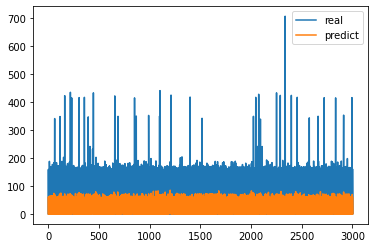

Epoch: 10; Test MAE loss on source data is: 39.038
Epoch: 10; Test MSE loss on source data is: 2854.845


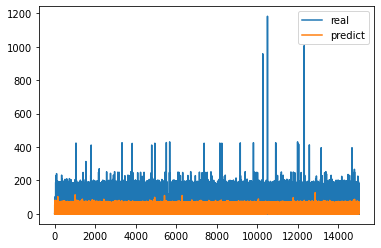

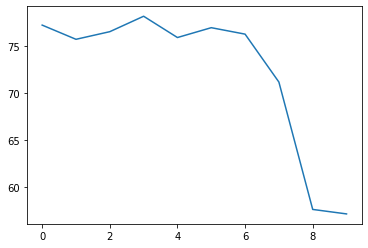

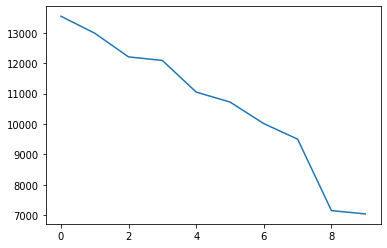

------------Domain Adaptation------------
Epoch: 0; MSE loss: 684579.718
Epoch: 0; disc loss: 79755.504
57.070125830690046
6827.680509844748
Parameter containing:
tensor([0.2010, 0.1994, 0.2006, 0.2004, 0.1986], device='cuda:0',
       requires_grad=True)
Epoch: 1; MSE loss: 694424.110
Epoch: 1; disc loss: 43464.497
58.10527555887905
6905.30450068441
Parameter containing:
tensor([0.1999, 0.1965, 0.2065, 0.1946, 0.2025], device='cuda:0',
       requires_grad=True)
Epoch: 2; MSE loss: 645479.840
Epoch: 2; disc loss: 47492.164
58.511211713591635
6994.891970377993
Parameter containing:
tensor([0.1915, 0.1887, 0.2169, 0.1924, 0.2105], device='cuda:0',
       requires_grad=True)
Epoch: 3; MSE loss: 655406.849
Epoch: 3; disc loss: 53354.384
56.0516053863594
6347.647704899727
Parameter containing:
tensor([0.1957, 0.1984, 0.2018, 0.1977, 0.2065], device='cuda:0',
       requires_grad=True)
Epoch: 4; MSE loss: 694079.839
Epoch: 4; disc loss: 51218.712
55.46262219021758
6357.148378887514
Paramete

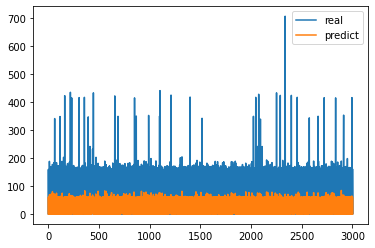

Epoch: 9; Test MAE loss on source data is: 40.558


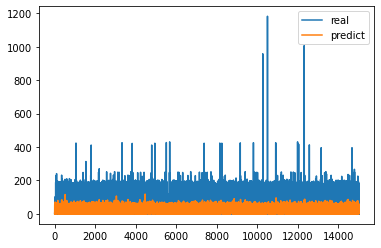

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


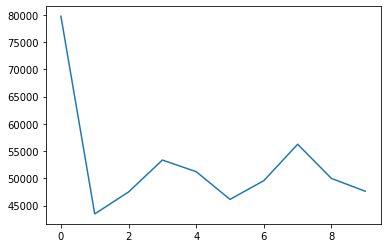

-------------------------- total running losses in 10 epoches as follows---------------------------------


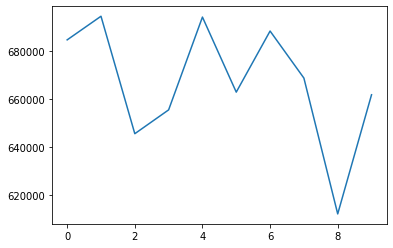

Epoch: 10; MSE loss: 622865.870
Epoch: 10; disc loss: 40720.324
54.48048668792922
6119.195057202932
Parameter containing:
tensor([0.1671, 0.3880, 0.2653, 0.1464, 0.0331], device='cuda:0',
       requires_grad=True)
Epoch: 11; MSE loss: 618264.600
Epoch: 11; disc loss: 33090.019
58.505293475393714
6945.0366803548895
Parameter containing:
tensor([0.1523, 0.4296, 0.2609, 0.1372, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 12; MSE loss: 655209.497
Epoch: 12; disc loss: 31642.963
56.456638743698306
6528.683879360014
Parameter containing:
tensor([0.1338, 0.4639, 0.2531, 0.1292, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 13; MSE loss: 609526.998
Epoch: 13; disc loss: 28479.382
53.5520482786691
5945.67143900238
Parameter containing:
tensor([0.1056, 0.5034, 0.2475, 0.1235, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 14; MSE loss: 580106.722
Epoch: 14; disc loss: 24412.766
57.10068651806287
6747.236954772273
Parameter containing:
tensor([0.0695, 0

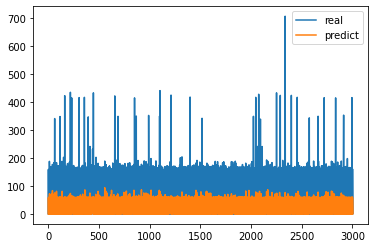

Epoch: 19; Test MAE loss on source data is: 39.910


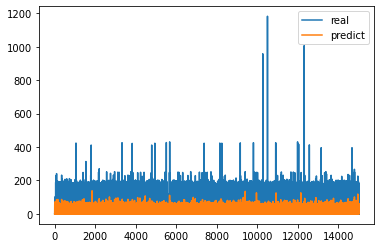

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


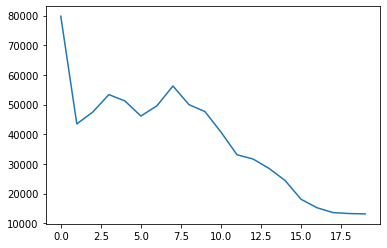

-------------------------- total running losses in 10 epoches as follows---------------------------------


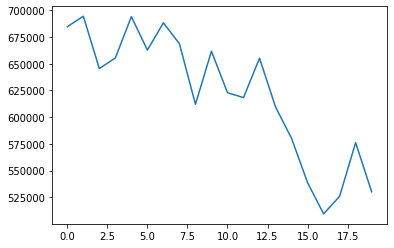

Epoch: 20; MSE loss: 496279.363
Epoch: 20; disc loss: 14979.750
58.509711931952765
7078.438494000464
Parameter containing:
tensor([0.0200, 0.7547, 0.1625, 0.0428, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 21; MSE loss: 574170.316
Epoch: 21; disc loss: 15429.738
56.97856332910654
6695.310830252766
Parameter containing:
tensor([0.0200, 0.7966, 0.1397, 0.0237, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 22; MSE loss: 527329.756
Epoch: 22; disc loss: 14485.288
56.479211044745405
6560.587513158361
Parameter containing:
tensor([0.0200, 0.8253, 0.1147, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 23; MSE loss: 526315.071
Epoch: 23; disc loss: 14956.839
55.165933892124244
6307.444011934183
Parameter containing:
tensor([0.0200, 0.8610, 0.0790, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 24; MSE loss: 462958.480
Epoch: 24; disc loss: 15573.732
55.807238818035096
6454.741659222575
Parameter containing:
tensor([0.0200

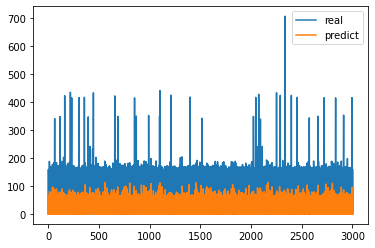

Epoch: 29; Test MAE loss on source data is: 38.698


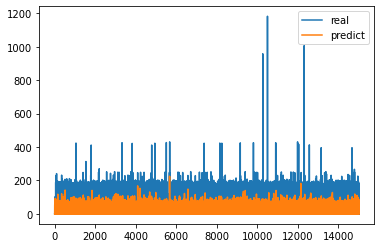

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


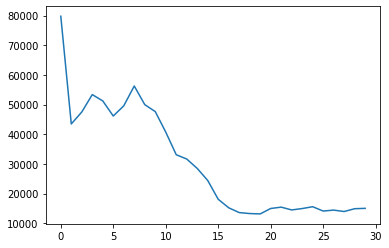

-------------------------- total running losses in 10 epoches as follows---------------------------------


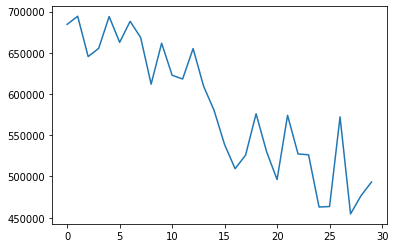

Epoch: 30; MSE loss: 499913.583
Epoch: 30; disc loss: 15534.738
55.69436487964906
6403.367592309106
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 31; MSE loss: 454650.600
Epoch: 31; disc loss: 16138.589
55.15605332131287
6327.172235378451
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 32; MSE loss: 526032.880
Epoch: 32; disc loss: 17128.829
56.418883816710704
6614.985397358367
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 33; MSE loss: 463138.890
Epoch: 33; disc loss: 18872.118
57.4639851040328
6855.506207828175
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 34; MSE loss: 460011.735
Epoch: 34; disc loss: 18574.518
56.99601930529012
6717.570299686916
Parameter containing:
tensor([0.0200, 0.

KeyboardInterrupt: 

In [8]:
import importlib
# import models.hdisc_msda 
# importlib.reload(models.hdisc_msda)
# from models.hdisc_msda import Disc_MSDANet
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =10,40

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in [1,2,5]:
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.0001
        lr1=0.00001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
        lr = 0.0001
        lr1=0.000001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(2):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
                for c in range(1):
                    loss0=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(2):
                    alpha_loss0=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)

In [9]:
trainfile1="F:/NILM/training_data/fridge_house_3_training_.csv"
trainfile2="F:/NILM/refit_training/fridge/fridge_house_15_training_.csv"
fileList=[trainfile1,trainfile2]
stepsizeList=[2,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=50
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[18353, 18353]



 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 0 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 587128.250
47.250524991476155
6428.114556696188
Epoch: 1; MSE loss: 538348.500
47.99224403219088
6721.769737480146
Epoch: 2; MSE loss: 560200.750
48.80290861171178
6261.376933847535
Epoch: 3; MSE loss: 465474.781
50.12675248231094
6212.487888170846
Epoch: 4; MSE loss: 422779.875
50.578016091327214
5666.84646619474
Epoch: 5; MSE loss: 457100.531
51.98331468185336
5354.15476207488
Epoch: 6; MSE loss: 410861.875
51.34470875300775
5268.9530358844095
Epoch: 7; MSE loss: 488190.812
52.10563897863024
5220.872688809933
Epoch: 8; MSE loss: 449394.531
50.99486663003287
5211.490499113466
Epoch: 9; MSE loss: 413616.281
50.7347738103809
5131.057095844265
Epoch: 10; Test MAE loss on target data is: 50.735
Epoch: 10; Test MSE loss on target data is: 5131.057


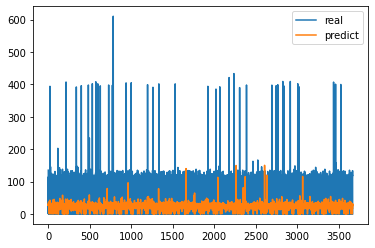

Epoch: 10; Test MAE loss on source data is: 31.476
Epoch: 10; Test MSE loss on source data is: 1668.483


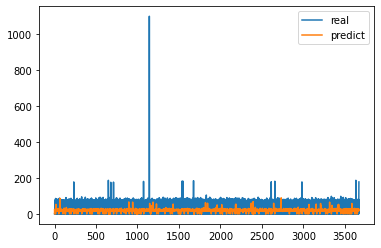

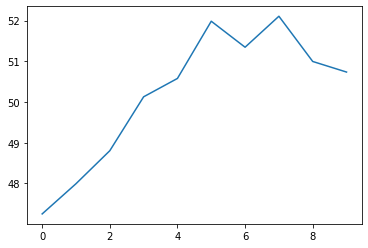

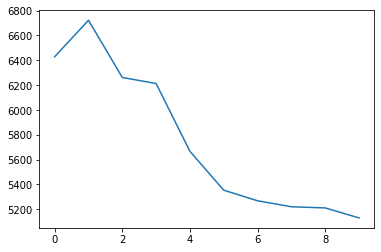

------------Domain Adaptation------------
Epoch: 0; MSE loss: 455792.888
Epoch: 0; disc loss: 28347.839
51.795547498005305
4967.058061096075
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 424103.609
Epoch: 1; disc loss: 12796.028
49.04511104002264
4943.009630100356
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 375128.177
Epoch: 2; disc loss: 11391.055
49.56656575434044
5159.289610692488
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 397472.145
Epoch: 3; disc loss: 15225.203
49.06561318793003
4961.237683906723
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 431403.269
Epoch: 4; disc loss: 15928.752
49.32435910037728
4970.9455841511335
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 5; MSE loss: 408662.709
Epoch: 5; disc loss: 12091.168
50.820973708195986
4669.324366917714
Paramet

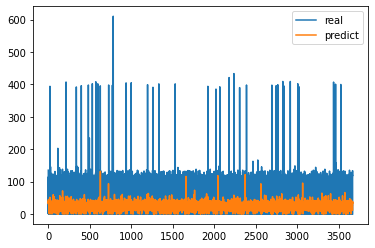

Epoch: 9; Test MAE loss on source data is: 30.916


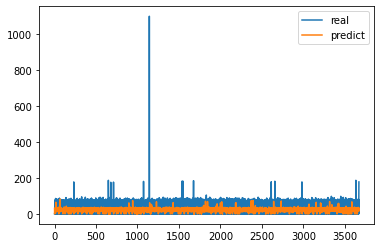

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


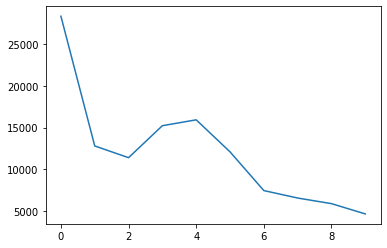

-------------------------- total running losses in 10 epoches as follows---------------------------------


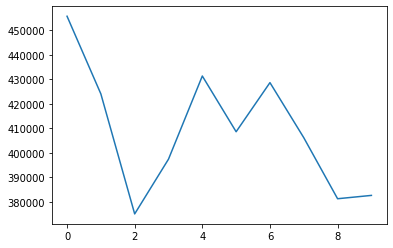

Epoch: 10; MSE loss: 393920.254
Epoch: 10; disc loss: 3038.926
51.00944735930703
4875.386359320828
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 423693.441
Epoch: 11; disc loss: 3215.663
47.07741771493075
4749.934815102322
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 426349.147
Epoch: 12; disc loss: 3269.904
47.59924513954
4690.3984464721025
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 385239.683
Epoch: 13; disc loss: 3403.560
46.24242635070872
4935.426168590204
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 404851.354
Epoch: 14; disc loss: 4466.473
49.08034616141827
4846.491198669769
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 15; MSE loss: 400303.948
Epoch: 15; disc loss: 4812.602
48.60608374671976
4822.863118355405
Parameter containing:
tensor([1.], device='cuda:

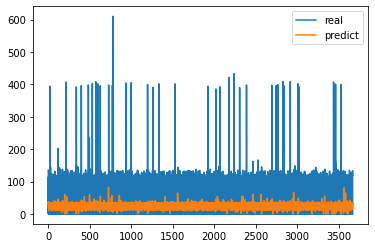

Epoch: 19; Test MAE loss on source data is: 30.729


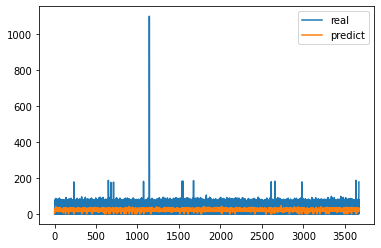

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


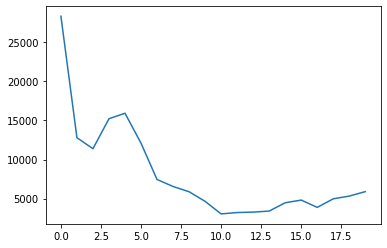

-------------------------- total running losses in 10 epoches as follows---------------------------------


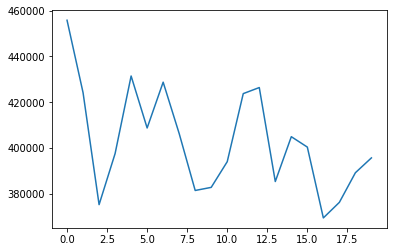

Epoch: 20; MSE loss: 373964.471
Epoch: 20; disc loss: 4714.575
47.45783158357144
4735.702033489062
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 21; MSE loss: 374425.211
Epoch: 21; disc loss: 4292.437
50.977316264288746
4712.4946614998
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 22; MSE loss: 371561.138
Epoch: 22; disc loss: 5052.898
47.32543489022518
4744.628688656265
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 23; MSE loss: 388190.124
Epoch: 23; disc loss: 6004.602
47.64609116694697
4453.50481386945
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 24; MSE loss: 365933.926
Epoch: 24; disc loss: 6808.349
47.053661121579964
4603.897259662391
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 25; MSE loss: 394508.316
Epoch: 25; disc loss: 6728.572
48.13708926717148
4718.175740886574
Parameter containing:
tensor([1.], device='cuda

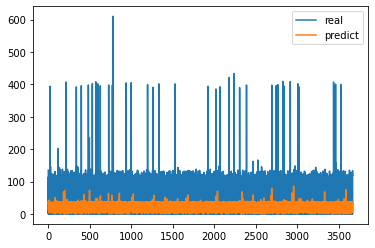

Epoch: 29; Test MAE loss on source data is: 28.319


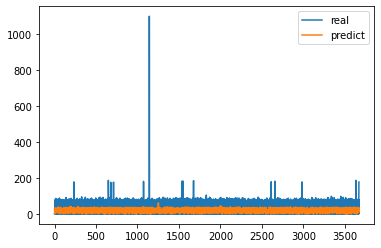

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


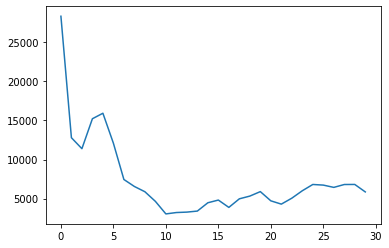

-------------------------- total running losses in 10 epoches as follows---------------------------------


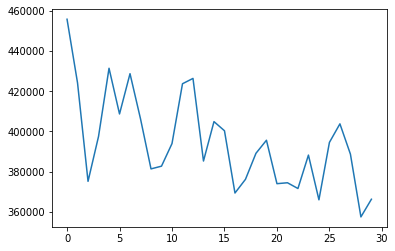

Epoch: 30; MSE loss: 347759.215
Epoch: 30; disc loss: 7062.339
46.49224318612242
4722.360699052891
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 31; MSE loss: 350978.364
Epoch: 31; disc loss: 6778.270
47.76986021934062
4710.237793617282
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 32; MSE loss: 343250.019
Epoch: 32; disc loss: 6728.024
47.47526140766086
4752.848614279247
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 33; MSE loss: 366033.554
Epoch: 33; disc loss: 6474.254
45.88206609859244
4699.907123723869
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 34; MSE loss: 337314.966
Epoch: 34; disc loss: 6275.238
46.314946513009055
4655.764949700754
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 35; MSE loss: 349188.690
Epoch: 35; disc loss: 5525.630
48.59076957600401
4674.065914659977
Parameter containing:
tensor([1.], device='cu

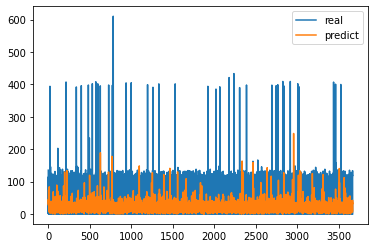

Epoch: 39; Test MAE loss on source data is: 28.450


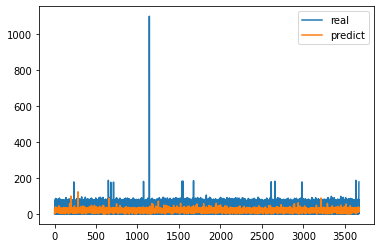

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


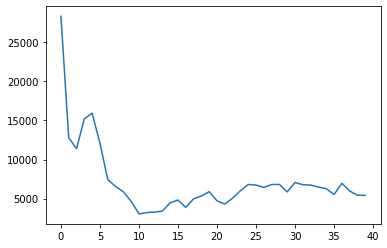

-------------------------- total running losses in 10 epoches as follows---------------------------------


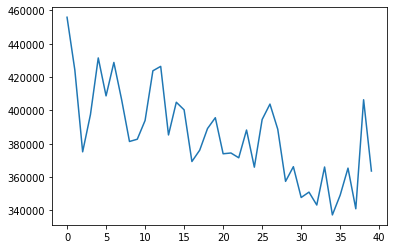

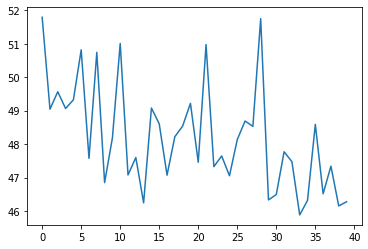

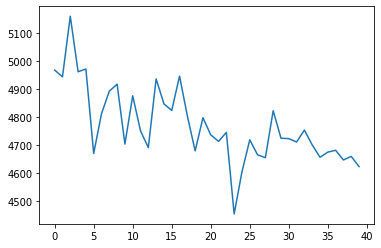

46.27616062197754
0.4918106066713287
0.8126901031327416
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)


In [10]:
import importlib
# import models.hdisc_msda 
# importlib.reload(models.hdisc_msda)
# from models.hdisc_msda import Disc_MSDANet
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =10,40

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in [0]:
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.0001
        lr1=0.00001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
        lr = 0.0001
        lr1=0.000001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(2):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
                for c in range(1):
                    loss0=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(2):
                    alpha_loss0=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)

In [13]:
trainfile1="F:/NILM/training_data/washingmachine_house_3_training_.csv"
trainfile2="F:/NILM/refit_training/washingmachine/washingmachine_house_16_training_.csv"
fileList=[trainfile1,trainfile2]
stepsizeList=[2,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=20
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[18353, 18353]



 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 0 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 8877966.000
37.221626109028975
75556.7996736208
Epoch: 1; MSE loss: 8178072.000
38.55201143314924
74594.42726336699
Epoch: 2; MSE loss: 9540230.000
41.088325798928246
76230.10546881982
Epoch: 3; MSE loss: 8483263.000
39.992693891651534
69838.92757095236
Epoch: 4; MSE loss: 9437881.000
42.758498070402496
72152.69590410264
Epoch: 5; MSE loss: 9262352.000
48.249595707008595
76224.2627910287
Epoch: 6; MSE loss: 9439992.000
44.08696541103146
67229.00642760175
Epoch: 7; MSE loss: 8872914.000
45.48110159204488
68753.8862044252
Epoch: 8; MSE loss: 8560121.000
47.1016525075301
67938.46734073231
Epoch: 9; MSE loss: 8158167.000
43.000205599319216
71430.93846513172
Epoch: 10; Test MAE loss on target data is: 43.000
Epoch: 10; Test MSE loss on target data is: 71430.938


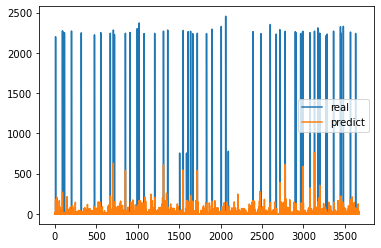

Epoch: 10; Test MAE loss on source data is: 34.158
Epoch: 10; Test MSE loss on source data is: 29907.116


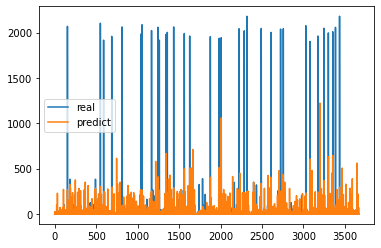

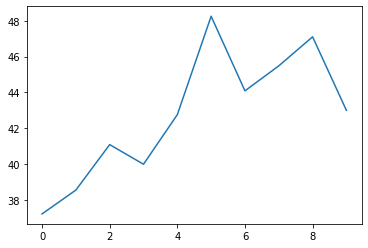

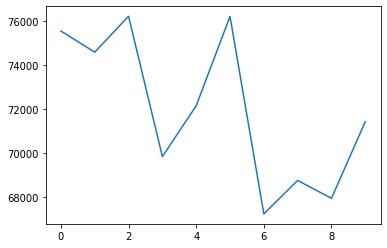

------------Domain Adaptation------------
Epoch: 0; MSE loss: 4628038.580
Epoch: 0; disc loss: 75910.757
44.18302255796929
75704.79995431355
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 4436837.693
Epoch: 1; disc loss: 48057.835
45.887540254807526
74323.55106502207
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 4732421.809
Epoch: 2; disc loss: 35920.593
41.959128038761015
74319.18760188567
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 5179457.041
Epoch: 3; disc loss: 17425.628
42.91407984633241
74433.28430915572
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 4368601.356
Epoch: 4; disc loss: 10788.236
44.70272869910088
79088.1915160913
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 5; MSE loss: 4561764.992
Epoch: 5; disc loss: 9882.411
41.18434282905611
77128.15657944095
Para

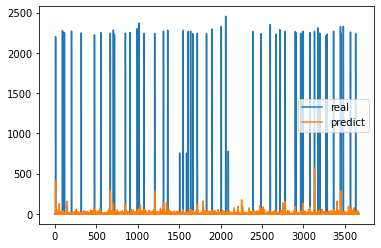

Epoch: 9; Test MAE loss on source data is: 26.340


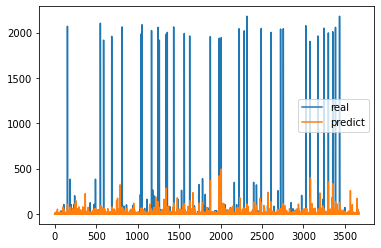

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


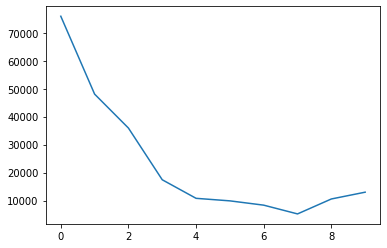

-------------------------- total running losses in 10 epoches as follows---------------------------------


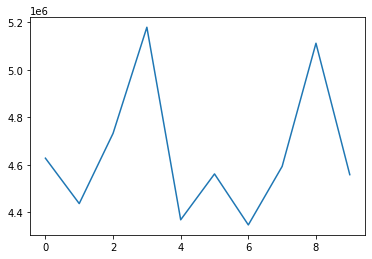

Epoch: 10; MSE loss: 4819495.884
Epoch: 10; disc loss: 7755.184
38.51473451761819
76738.44240136699
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 4999468.429
Epoch: 11; disc loss: 3258.232
39.56034178877364
78678.37679326271
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 4541957.214
Epoch: 12; disc loss: 5253.527
39.17237234563799
79023.19493310885
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 4952137.456
Epoch: 13; disc loss: 12779.253
42.95835207754398
74512.7253621303
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 4443049.804
Epoch: 14; disc loss: 18081.233
39.30919171944612
77820.28063166041
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 15; MSE loss: 4582208.562
Epoch: 15; disc loss: 14331.657
40.428389088769165
77041.58169421149
Parameter containing:
tensor([1.], de

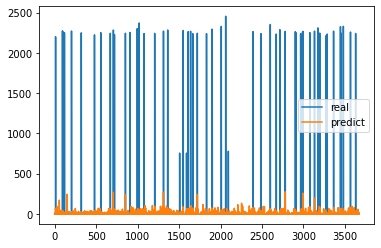

Epoch: 19; Test MAE loss on source data is: 26.565


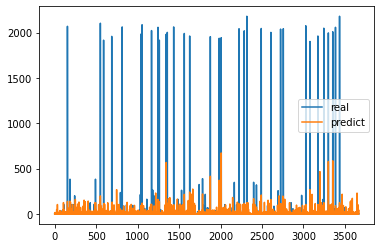

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


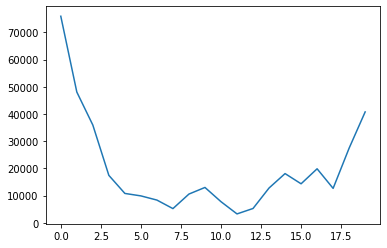

-------------------------- total running losses in 10 epoches as follows---------------------------------


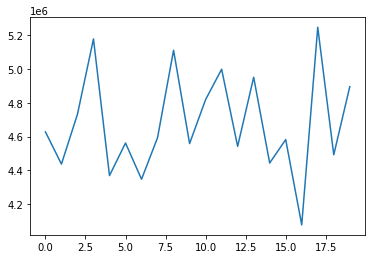

Epoch: 20; MSE loss: 4394371.054
Epoch: 20; disc loss: 40820.960
41.828212257111026
77974.98440627089
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 21; MSE loss: 3970387.349
Epoch: 21; disc loss: 27448.427
40.58727485414492
76466.2984951555
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 22; MSE loss: 4637914.269
Epoch: 22; disc loss: 39082.619
41.10292962334815
76348.77076362979
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 23; MSE loss: 4417936.938
Epoch: 23; disc loss: 38370.029
41.59714079546895
76759.66326379373
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 24; MSE loss: 4414301.446
Epoch: 24; disc loss: 49492.278
41.683442782421054
77472.78583028087
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 25; MSE loss: 3869533.941
Epoch: 25; disc loss: 43137.889
40.867874976376086
78349.60070556983
Parameter containing:
tensor([1.

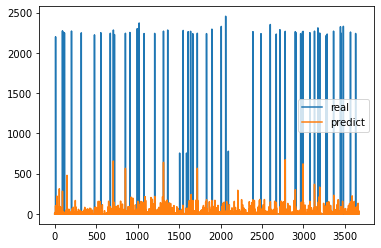

Epoch: 29; Test MAE loss on source data is: 33.115


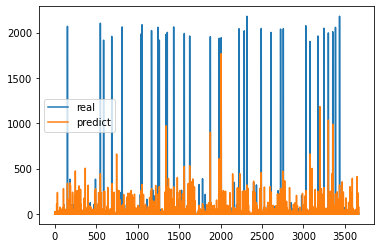

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


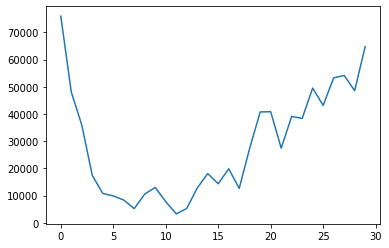

-------------------------- total running losses in 10 epoches as follows---------------------------------


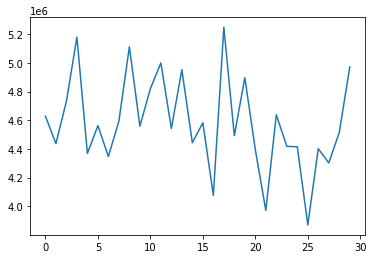

Epoch: 30; MSE loss: 4094517.724
Epoch: 30; disc loss: 41611.925
42.37421186205531
79728.05856811193
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 31; MSE loss: 4568132.890
Epoch: 31; disc loss: 38189.649
44.273223730231805
71726.7830735509
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 32; MSE loss: 5058515.827
Epoch: 32; disc loss: 59331.944
39.19670477000852
75517.3517933794
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 33; MSE loss: 4629207.518
Epoch: 33; disc loss: 26313.673
43.23566217106781
76095.99303075095
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 34; MSE loss: 4958072.615
Epoch: 34; disc loss: 68557.921
42.498118872292714
75300.36936128
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)
Epoch: 35; MSE loss: 4658826.254
Epoch: 35; disc loss: 37816.837
41.23753797739671
77614.18075403092
Parameter containing:
tensor([1.], de

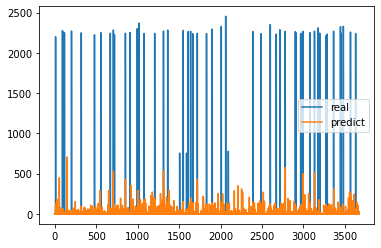

Epoch: 39; Test MAE loss on source data is: 31.717


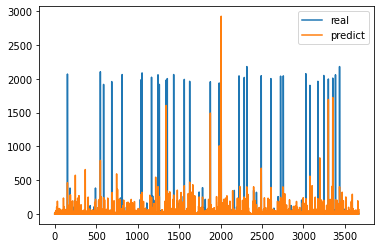

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


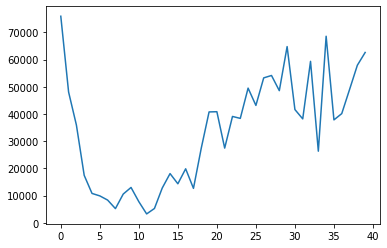

-------------------------- total running losses in 10 epoches as follows---------------------------------


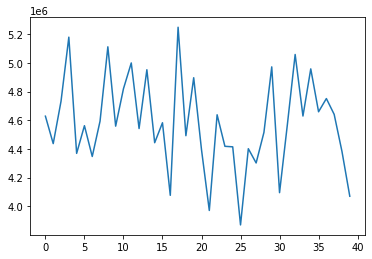

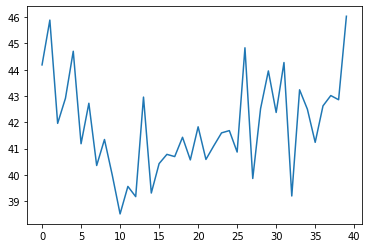

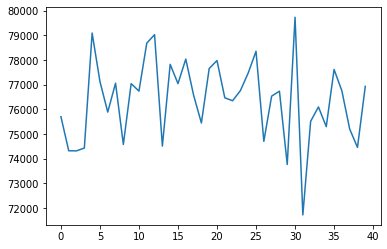

46.03409737423921
0.6492722525373267
0.9795056056702527
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)


In [14]:
import importlib
# import models.hdisc_msda 
# importlib.reload(models.hdisc_msda)
# from models.hdisc_msda import Disc_MSDANet
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =10,40

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in [0]:
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.0001
        lr1=0.00001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
        lr = 0.0001
        lr1=0.000001
        batch_size =123
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(2):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
                for c in range(1):
                    loss0=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(2):
                    alpha_loss0=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)

In [9]:
# ######################################washingmachine###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# # trainfile1="/content/drive/MyDrive/training_data/washingmachine_house_2_training_.csv"
# trainfile1="training_data/washingmachine_test_.csv"

# trainfile2="ukdale_training/washingmachine_house_1_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="refit_training/washingmachine/washingmachine_house_9_training_.csv"
# trainfile4="refit_training/washingmachine/washingmachine_house_16_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=20
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

######################################washingmachine###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# # trainfile1="/content/drive/MyDrive/training_data/washingmachine_house_2_training_.csv"
# trainfile1="/content/drive/MyDrive/training_data/washingmachine_test_.csv"

# trainfile2="/content/drive/MyDrive/ukdale_training/washingmachine_house_1_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="/content/drive/MyDrive/refit_training/washingmachine/washingmachine_house_9_training_.csv"
# trainfile4="/content/drive/MyDrive/refit_training/washingmachine/washingmachine_house_16_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
trainfile1="training_data/washingmachine_test_.csv"
trainfile2="training_data/washingmachine_house_2_training_.csv"
trainfile3="ukdale_training/washingmachine_house_1_training_.csv"
trainfile4="ukdale_training/washingmachine_house_2_training_.csv"
trainfile5="refit_training/washingmachine/washingmachine_house_9_training_.csv"
trainfile6="refit_training/washingmachine/washingmachine_house_16_training_.csv"
fileList=[trainfile1,trainfile2,trainfile3,trainfile4,trainfile5,trainfile6]
stepsizeList=[2,2,16,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=20
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[15017, 15017, 15017, 15017, 15017, 15017]



 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 0 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 4943001.000
32.48476174325156
77753.9933879301
Epoch: 1; MSE loss: 4253462.000
33.372332652090336
71333.00498463522
Epoch: 2; MSE loss: 4243717.500
33.10218384740002
70398.99207632965
Epoch: 3; MSE loss: 4116461.750
33.455650956237456
70158.96727964602
Epoch: 4; MSE loss: 3870217.750
33.284067938370484
71063.97173270582
Epoch: 5; MSE loss: 4039952.500
34.577368869763276
66867.87586222486
Epoch: 6; MSE loss: 4295922.000
33.69327341586424
75837.6653342214
Epoch: 7; MSE loss: 4296249.500
33.11811577395486
74851.84073705356
Epoch: 8; MSE loss: 4374275.000
32.954698806543846
70629.10919342775
Epoch: 9; MSE loss: 4142255.250
33.2058131090174
73440.59967476611
Epoch: 10; Test MAE loss on target data is: 33.206
Epoch: 10; Test MSE loss on target data is: 73440.600


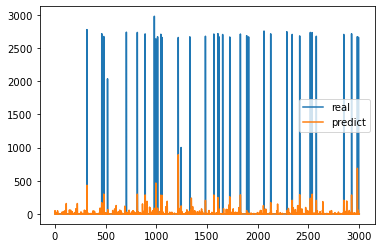

Epoch: 10; Test MAE loss on source data is: 17.937
Epoch: 10; Test MSE loss on source data is: 18176.605


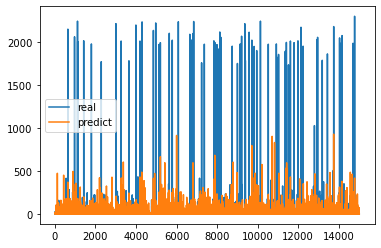

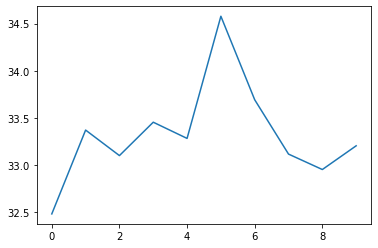

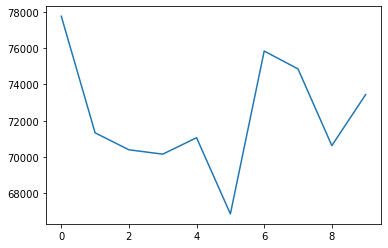

------------Domain Adaptation------------
Epoch: 0; MSE loss: 4303976.165
Epoch: 0; disc loss: 173892.738
34.74189289060681
68051.7185455947
Parameter containing:
tensor([0.1997, 0.2024, 0.1993, 0.1999, 0.1988], device='cuda:0',
       requires_grad=True)
Epoch: 1; MSE loss: 3888814.171
Epoch: 1; disc loss: 92548.286
33.336744689139756
74152.2197896929
Parameter containing:
tensor([0.1962, 0.2108, 0.1971, 0.1979, 0.1980], device='cuda:0',
       requires_grad=True)
Epoch: 2; MSE loss: 4728027.492
Epoch: 2; disc loss: 33960.070
33.233162044781466
79214.02605486535
Parameter containing:
tensor([0.1877, 0.2204, 0.1922, 0.1981, 0.2017], device='cuda:0',
       requires_grad=True)
Epoch: 3; MSE loss: 4844025.586
Epoch: 3; disc loss: 28008.620
32.6743013842558
81513.47373472092
Parameter containing:
tensor([0.1806, 0.2218, 0.1881, 0.2025, 0.2070], device='cuda:0',
       requires_grad=True)
Epoch: 4; MSE loss: 4843387.324
Epoch: 4; disc loss: 33839.316
32.7058313703582
80184.96570770022
Para

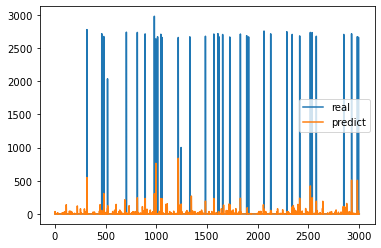

Epoch: 9; Test MAE loss on source data is: 16.424


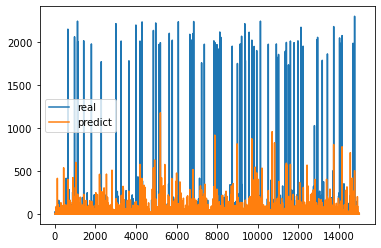

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


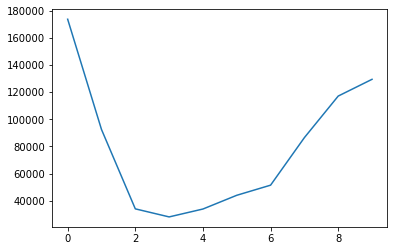

-------------------------- total running losses in 10 epoches as follows---------------------------------


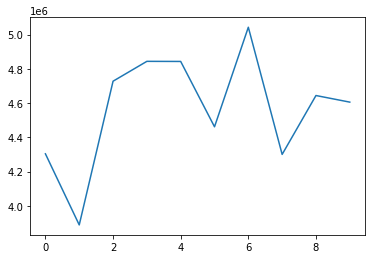

Epoch: 10; MSE loss: 4797838.691
Epoch: 10; disc loss: 129253.635
34.021376459656764
73858.61810464785
Parameter containing:
tensor([0.1542, 0.2462, 0.1626, 0.2148, 0.2221], device='cuda:0',
       requires_grad=True)
Epoch: 11; MSE loss: 5017039.129
Epoch: 11; disc loss: 123100.359
33.032455324452854
75318.96000041848
Parameter containing:
tensor([0.1489, 0.2485, 0.1545, 0.2200, 0.2282], device='cuda:0',
       requires_grad=True)
Epoch: 12; MSE loss: 4576149.234
Epoch: 12; disc loss: 124538.181
33.21467915924222
70858.5503844098
Parameter containing:
tensor([0.1428, 0.2481, 0.1469, 0.2255, 0.2367], device='cuda:0',
       requires_grad=True)
Epoch: 13; MSE loss: 5032841.621
Epoch: 13; disc loss: 123517.573
32.90400226833196
72252.33189586483
Parameter containing:
tensor([0.1363, 0.2456, 0.1407, 0.2314, 0.2460], device='cuda:0',
       requires_grad=True)
Epoch: 14; MSE loss: 4815233.832
Epoch: 14; disc loss: 108470.854
33.127584497796114
80410.23051632478
Parameter containing:
tensor

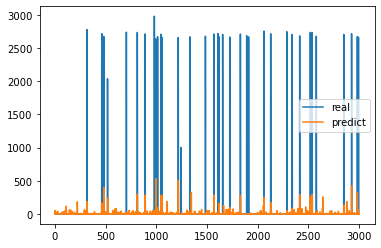

Epoch: 19; Test MAE loss on source data is: 16.411


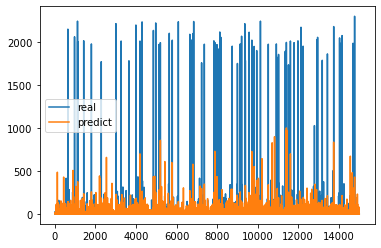

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


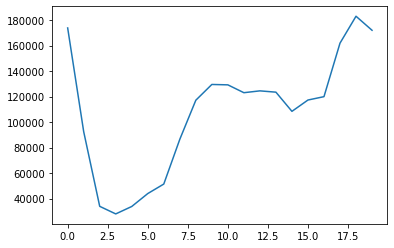

-------------------------- total running losses in 10 epoches as follows---------------------------------


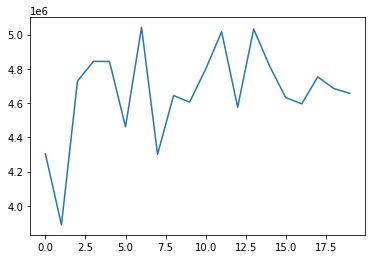

Epoch: 20; MSE loss: 4850271.035
Epoch: 20; disc loss: 207636.478
32.963799628932186
75734.22781621166
Parameter containing:
tensor([0.0982, 0.1693, 0.1106, 0.3119, 0.3100], device='cuda:0',
       requires_grad=True)
Epoch: 21; MSE loss: 4515832.045
Epoch: 21; disc loss: 225457.364
32.58855439606795
74058.41468185616
Parameter containing:
tensor([0.0952, 0.1586, 0.1109, 0.3216, 0.3137], device='cuda:0',
       requires_grad=True)
Epoch: 22; MSE loss: 4578452.389
Epoch: 22; disc loss: 233455.496
33.28538470038763
84296.17522349909
Parameter containing:
tensor([0.0922, 0.1449, 0.1113, 0.3334, 0.3182], device='cuda:0',
       requires_grad=True)
Epoch: 23; MSE loss: 4444286.617
Epoch: 23; disc loss: 224708.960
32.878127279557056
75407.94114092932
Parameter containing:
tensor([0.0892, 0.1353, 0.1114, 0.3438, 0.3203], device='cuda:0',
       requires_grad=True)
Epoch: 24; MSE loss: 4453786.218
Epoch: 24; disc loss: 248671.813
32.82856424212707
75534.50989610066
Parameter containing:
tensor

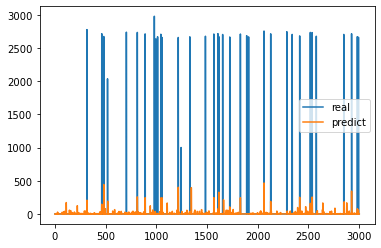

Epoch: 29; Test MAE loss on source data is: 15.994


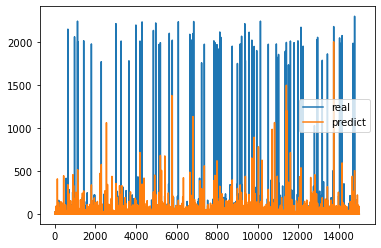

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


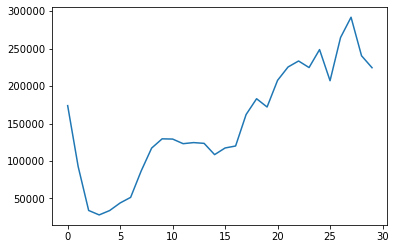

-------------------------- total running losses in 10 epoches as follows---------------------------------


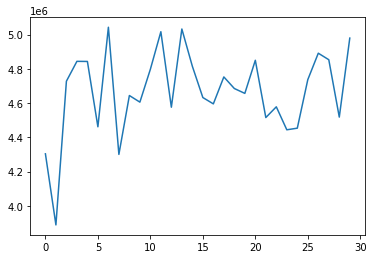

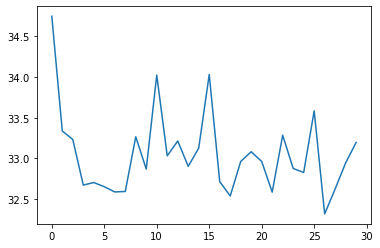

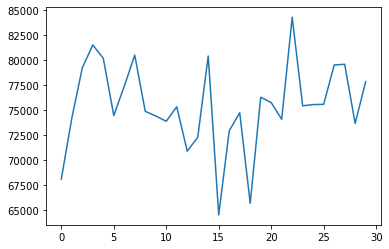

33.19699532338581
0.8710453459096549
0.9512641985646095
Parameter containing:
tensor([0.0607, 0.0483, 0.1108, 0.4111, 0.3691], device='cuda:0',
       requires_grad=True)

---------------------------------------------- domain num 2 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 7399821.500
25.482420728811014
34954.627925232766
Epoch: 1; MSE loss: 6942767.500
26.627227073196774
33321.5650436177
Epoch: 2; MSE loss: 7485569.500
27.686615547707202
32097.677180728304
Epoch: 3; MSE loss: 6538089.000
28.726381507898108
31108.0596920457
Epoch: 4; MSE loss: 6514972.500
27.903843818058803
31795.161216881144
Epoch: 5; MSE loss: 6189872.000
29.571049214084045
30823.1930032081
Epoch: 6; MSE loss: 6191610.500
28.98020317900018
29870.591835255073
Epoch: 7; MSE loss: 6058537.500
28.45412666553981
30963.739726129206
Epoch: 8; MSE loss: 6196959.000
28.642871466008312
30274.82925147067
Epoch: 9; MSE loss: 5798383.000
29.450031807008738
29499.32781461

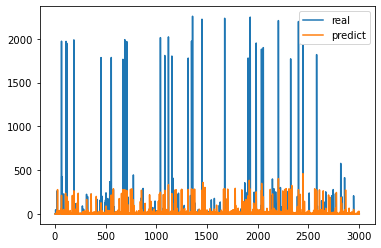

Epoch: 10; Test MAE loss on source data is: 26.563
Epoch: 10; Test MSE loss on source data is: 23272.472


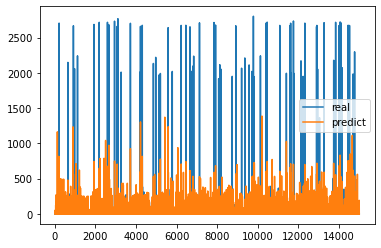

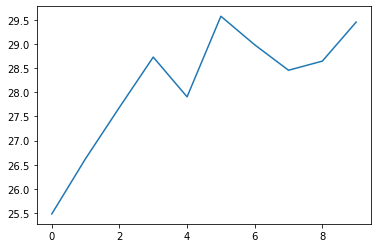

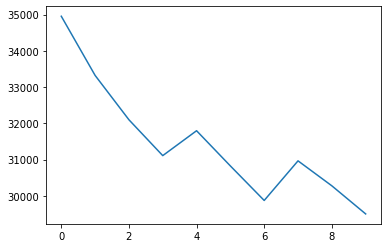

------------Domain Adaptation------------
Epoch: 0; MSE loss: 6484700.237
Epoch: 0; disc loss: 245535.663
27.470600170848492
36975.71231061598
Parameter containing:
tensor([0.2016, 0.1977, 0.2004, 0.2008, 0.1996], device='cuda:0',
       requires_grad=True)
Epoch: 1; MSE loss: 6747908.530
Epoch: 1; disc loss: 30093.309
26.909038717792768
37451.3027418696
Parameter containing:
tensor([0.2051, 0.1976, 0.1989, 0.1984, 0.1999], device='cuda:0',
       requires_grad=True)
Epoch: 2; MSE loss: 7495201.464
Epoch: 2; disc loss: 5772.982
24.396960049688435
36667.71324283937
Parameter containing:
tensor([0.2045, 0.1987, 0.1990, 0.1979, 0.1999], device='cuda:0',
       requires_grad=True)
Epoch: 3; MSE loss: 7406104.615
Epoch: 3; disc loss: 19620.727
24.34936338400508
36811.56232797795
Parameter containing:
tensor([0.2008, 0.2013, 0.1996, 0.1973, 0.2011], device='cuda:0',
       requires_grad=True)
Epoch: 4; MSE loss: 6983727.019
Epoch: 4; disc loss: 11004.478
24.10949101528313
37255.247164475266


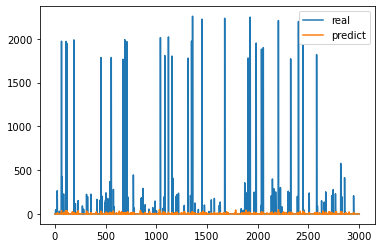

Epoch: 9; Test MAE loss on source data is: 15.601


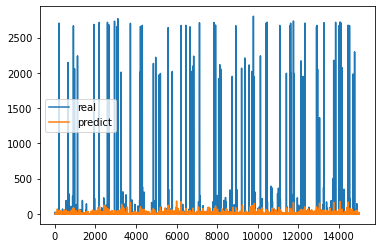

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


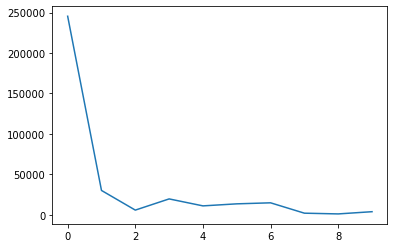

-------------------------- total running losses in 10 epoches as follows---------------------------------


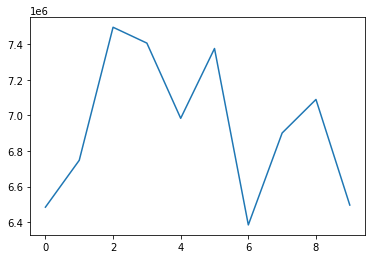

Epoch: 10; MSE loss: 7001685.396
Epoch: 10; disc loss: 4124.188
24.116315675577578
37033.24992023245
Parameter containing:
tensor([0.1698, 0.2191, 0.2032, 0.2077, 0.2002], device='cuda:0',
       requires_grad=True)
Epoch: 11; MSE loss: 6956190.658
Epoch: 11; disc loss: 17539.673
24.164211774469365
36740.24461741447
Parameter containing:
tensor([0.1682, 0.2206, 0.2005, 0.2106, 0.2001], device='cuda:0',
       requires_grad=True)
Epoch: 12; MSE loss: 7437660.478
Epoch: 12; disc loss: 9114.036
24.111772745845222
36920.4632420413
Parameter containing:
tensor([0.1634, 0.2229, 0.1996, 0.2133, 0.2008], device='cuda:0',
       requires_grad=True)
Epoch: 13; MSE loss: 6333330.974
Epoch: 13; disc loss: 7651.395
24.104060313136088
36995.47767265535
Parameter containing:
tensor([0.1552, 0.2265, 0.2015, 0.2163, 0.2005], device='cuda:0',
       requires_grad=True)
Epoch: 14; MSE loss: 6595896.521
Epoch: 14; disc loss: 8023.236
24.316480514759906
36334.31172651004
Parameter containing:
tensor([0.149

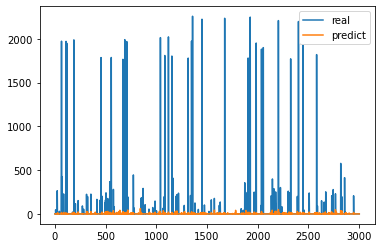

Epoch: 19; Test MAE loss on source data is: 15.456


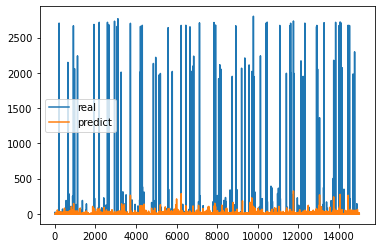

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


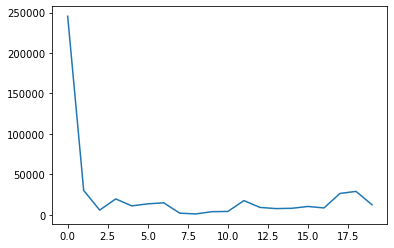

-------------------------- total running losses in 10 epoches as follows---------------------------------


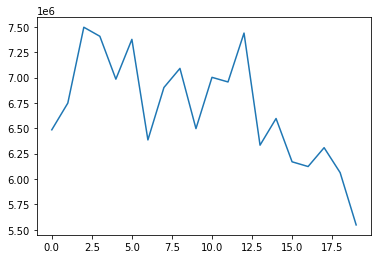

Epoch: 20; MSE loss: 5626432.415
Epoch: 20; disc loss: 41308.203
24.97429381743118
34323.48088000603
Parameter containing:
tensor([0.1105, 0.2280, 0.2248, 0.2422, 0.1945], device='cuda:0',
       requires_grad=True)
Epoch: 21; MSE loss: 5154634.308
Epoch: 21; disc loss: 26700.455
24.32910842846424
36470.36170913474
Parameter containing:
tensor([0.1084, 0.2263, 0.2294, 0.2425, 0.1933], device='cuda:0',
       requires_grad=True)
Epoch: 22; MSE loss: 5446008.951
Epoch: 22; disc loss: 19061.203
24.180002815281096
36802.908268511914
Parameter containing:
tensor([0.0957, 0.2295, 0.2325, 0.2466, 0.1957], device='cuda:0',
       requires_grad=True)
Epoch: 23; MSE loss: 5196882.454
Epoch: 23; disc loss: 14087.729
24.067043475491726
36783.14076078664
Parameter containing:
tensor([0.0818, 0.2329, 0.2373, 0.2497, 0.1983], device='cuda:0',
       requires_grad=True)
Epoch: 24; MSE loss: 4893433.234
Epoch: 24; disc loss: 39714.358
24.329876243325476
35349.03489810244
Parameter containing:
tensor([0

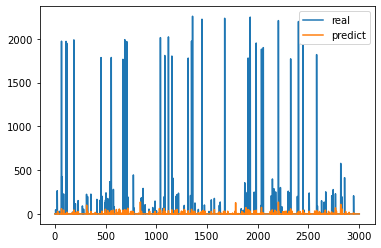

Epoch: 29; Test MAE loss on source data is: 15.903


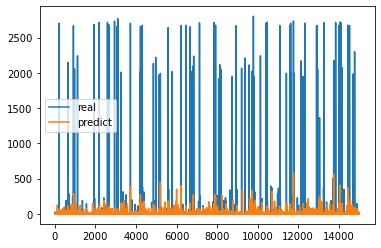

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


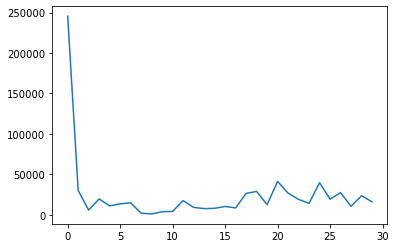

-------------------------- total running losses in 10 epoches as follows---------------------------------


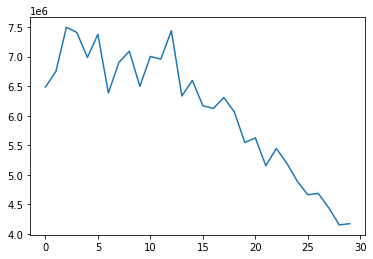

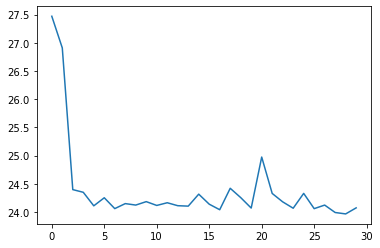

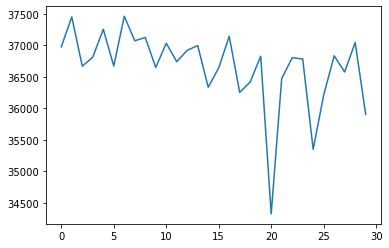

24.073362772756028
0.927379863188704
0.9781574468073166
Parameter containing:
tensor([0.0200, 0.2452, 0.2707, 0.2731, 0.1909], device='cuda:0',
       requires_grad=True)

---------------------------------------------- domain num 5 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 7203134.000
23.470607111251574
27252.41916768123
Epoch: 1; MSE loss: 6752538.000
26.919291110104755
26512.357714767422
Epoch: 2; MSE loss: 6822522.500
30.238766591925888
26030.402368117284
Epoch: 3; MSE loss: 6658778.000
32.66391359613005
26031.006296284086
Epoch: 4; MSE loss: 6638343.500
33.05254761347133
26288.858576006056
Epoch: 5; MSE loss: 6128597.500
35.81054519515202
25945.889284717567
Epoch: 6; MSE loss: 6554613.500
32.97129605253278
25771.50011152995
Epoch: 7; MSE loss: 6264598.500
33.43902085496289
29594.16726750648
Epoch: 8; MSE loss: 5966224.000
26.164599665279404
28157.55349477973
Epoch: 9; MSE loss: 6296749.500
36.33126834485824
27308.427605421

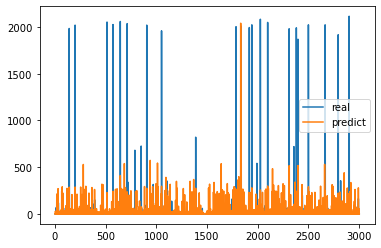

Epoch: 10; Test MAE loss on source data is: 25.377
Epoch: 10; Test MSE loss on source data is: 24029.830


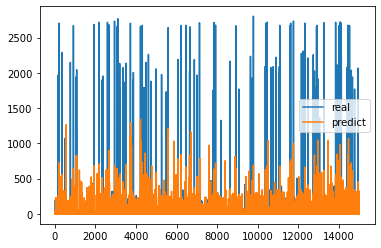

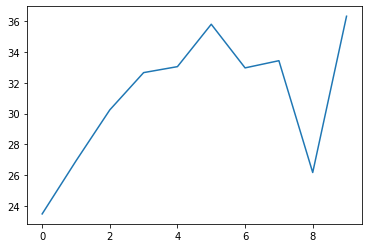

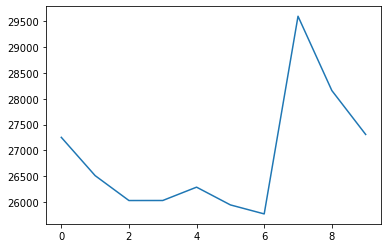

------------Domain Adaptation------------
Epoch: 0; MSE loss: 6715441.501
Epoch: 0; disc loss: 372371.911
35.612837913370484
25937.117261858257
Parameter containing:
tensor([0.2002, 0.2000, 0.2004, 0.1995, 0.1998], device='cuda:0',
       requires_grad=True)
Epoch: 1; MSE loss: 5970019.435
Epoch: 1; disc loss: 313441.087
29.96444300558175
26008.428585254595
Parameter containing:
tensor([0.2049, 0.1980, 0.2024, 0.1967, 0.1981], device='cuda:0',
       requires_grad=True)
Epoch: 2; MSE loss: 6114564.861
Epoch: 2; disc loss: 303453.315
27.19617303414084
27869.38390917166
Parameter containing:
tensor([0.2127, 0.1939, 0.2058, 0.1937, 0.1939], device='cuda:0',
       requires_grad=True)
Epoch: 3; MSE loss: 6244569.909
Epoch: 3; disc loss: 315641.966
27.651140940744558
26515.16388900485
Parameter containing:
tensor([0.2221, 0.1886, 0.2104, 0.1906, 0.1882], device='cuda:0',
       requires_grad=True)
Epoch: 4; MSE loss: 6644351.951
Epoch: 4; disc loss: 303353.751
23.58443547355398
27332.042059

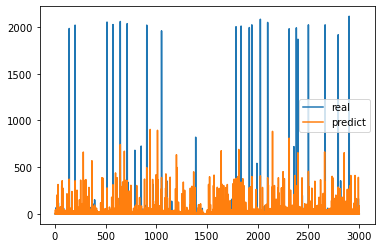

Epoch: 9; Test MAE loss on source data is: 24.902


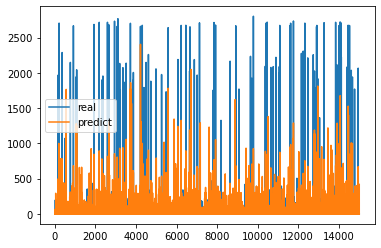

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


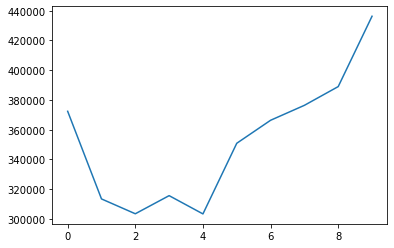

-------------------------- total running losses in 10 epoches as follows---------------------------------


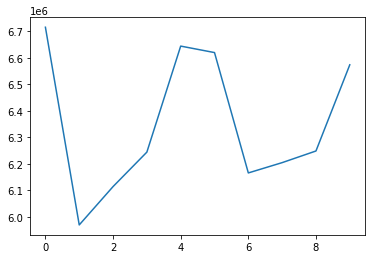

Epoch: 10; MSE loss: 6201803.940
Epoch: 10; disc loss: 448871.906
22.921655353252962
36785.418279098696
Parameter containing:
tensor([0.2345, 0.1556, 0.2762, 0.1700, 0.1636], device='cuda:0',
       requires_grad=True)
Epoch: 11; MSE loss: 6642852.805
Epoch: 11; disc loss: 583633.556
34.571987850731674
57677.172804915994
Parameter containing:
tensor([0.2265, 0.1518, 0.2872, 0.1675, 0.1669], device='cuda:0',
       requires_grad=True)
Epoch: 12; MSE loss: 6098069.736
Epoch: 12; disc loss: 677870.162
30.374387054000987
93247.03409307492
Parameter containing:
tensor([0.2185, 0.1466, 0.3011, 0.1633, 0.1704], device='cuda:0',
       requires_grad=True)
Epoch: 13; MSE loss: 5451288.354
Epoch: 13; disc loss: 647724.521
36.348735214402026
26472.156190306796
Parameter containing:
tensor([0.2102, 0.1454, 0.3097, 0.1615, 0.1732], device='cuda:0',
       requires_grad=True)
Epoch: 14; MSE loss: 5946526.074
Epoch: 14; disc loss: 788401.352
33.36691520704867
26261.768632739255
Parameter containing:


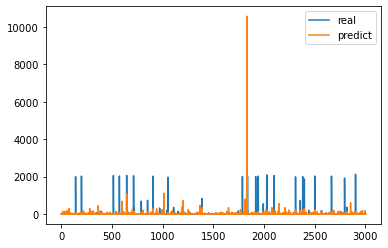

Epoch: 19; Test MAE loss on source data is: 17.048


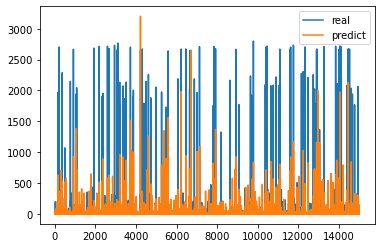

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


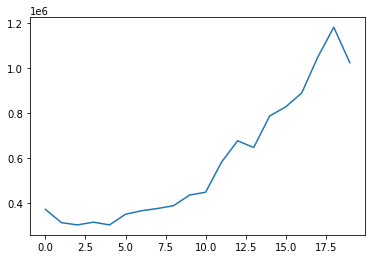

-------------------------- total running losses in 10 epoches as follows---------------------------------


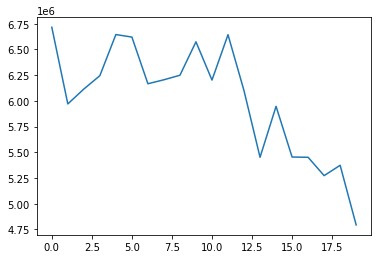

Epoch: 20; MSE loss: 5309630.647
Epoch: 20; disc loss: 1282643.902
26.242152560105456
33417.36785872542
Parameter containing:
tensor([0.1557, 0.1330, 0.3686, 0.1500, 0.1927], device='cuda:0',
       requires_grad=True)
Epoch: 21; MSE loss: 5067224.159
Epoch: 21; disc loss: 1442654.708
34.46350261004525
105198.77049260176
Parameter containing:
tensor([0.1486, 0.1329, 0.3749, 0.1480, 0.1957], device='cuda:0',
       requires_grad=True)
Epoch: 22; MSE loss: 5092569.682
Epoch: 22; disc loss: 1335198.599
37.936785465396554
130162.59102231964
Parameter containing:
tensor([0.1430, 0.1325, 0.3788, 0.1472, 0.1985], device='cuda:0',
       requires_grad=True)
Epoch: 23; MSE loss: 4901712.829
Epoch: 23; disc loss: 1667774.626
24.83824257306338
37467.31247893231
Parameter containing:
tensor([0.1365, 0.1325, 0.3811, 0.1467, 0.2032], device='cuda:0',
       requires_grad=True)
Epoch: 24; MSE loss: 4694127.604
Epoch: 24; disc loss: 1692491.353
27.754088063333704
39057.202241049956
Parameter containin

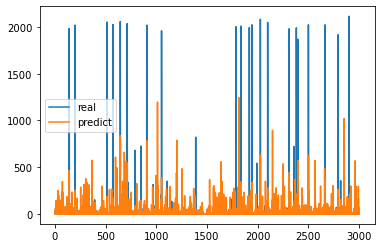

In [ ]:
import importlib
# import models.hdisc_msda 
# importlib.reload(models.hdisc_msda)
# from models.hdisc_msda import Disc_MSDANet
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =10,30

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in [0,2,5]:
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.0001
        lr1=0.00001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
        lr = 0.0001
        lr1=0.000001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(5):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
                for c in range(1):
                    loss0=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(1):
                    alpha_loss0=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)

In [11]:
# ######################################dishwasher###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="training_data/dishwasher_house_3_training_.csv"

# trainfile2="ukdale_training/dishwasher_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="refit_training/dishwasher/dishwasher_house_13_training_.csv"
# trainfile4="refit_training/dishwasher/dishwasher_house_18_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=10
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

trainfile1="training_data/dishwasher_test_.csv"
trainfile2="training_data/dishwasher_house_2_training_.csv"
trainfile3="ukdale_training/dishwasher_house_1_training_.csv"
trainfile4="ukdale_training/dishwasher_house_2_training_.csv"
trainfile5="refit_training/dishwasher/dishwasher_house_13_training_.csv"
trainfile6="refit_training/dishwasher/dishwasher_house_18_training_.csv"
fileList=[trainfile1,trainfile2,trainfile3,trainfile4,trainfile5,trainfile6]
stepsizeList=[2,2,16,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=10
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])

min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[15017, 15017, 15017, 15017, 15017, 15017]



 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 0 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 10861448.000
22.304027507543772
16484.545414411747
Epoch: 1; MSE loss: 10443294.000
25.297925965056482
16236.815494756278
Epoch: 2; MSE loss: 9570792.000
27.322707058892444
16899.450413784834
Epoch: 3; MSE loss: 9443425.000
28.18784319377462
16821.196014303532
Epoch: 4; MSE loss: 8855886.000
33.81136239313178
18311.85626616617
Epoch: 5; MSE loss: 8232057.500
36.23201816275144
20284.419726309232
Epoch: 6; MSE loss: 7984176.500
34.52758363661465
19961.509630290904
Epoch: 7; MSE loss: 8254927.500
41.58231508662231
27205.876032914446
Epoch: 8; MSE loss: 8366699.500
35.560972643766476
20607.98145973022
Epoch: 9; MSE loss: 7970318.500
37.11116964781068
21543.296751650083
Epoch: 10; Test MAE loss on target data is: 37.111
Epoch: 10; Test MSE loss on target data is: 

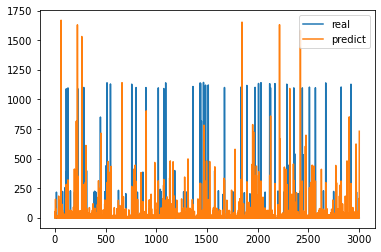

Epoch: 10; Test MAE loss on source data is: 39.924
Epoch: 10; Test MSE loss on source data is: 33667.099


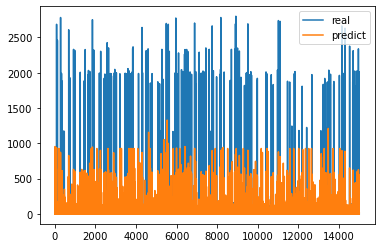

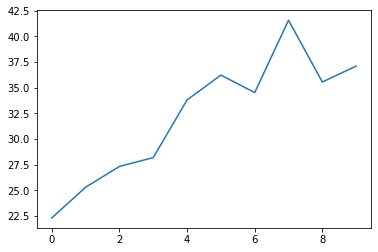

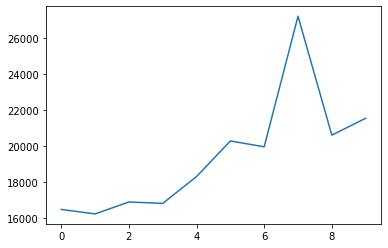

------------Domain Adaptation------------
Epoch: 0; MSE loss: 8184961.196
Epoch: 0; disc loss: 254927.084
31.89342565732916
20371.508217805604
Parameter containing:
tensor([0.1959, 0.2017, 0.2045, 0.1992, 0.1987], device='cuda:0',
       requires_grad=True)
Epoch: 1; MSE loss: 8647784.013
Epoch: 1; disc loss: 182532.434
40.32592065890121
27802.555567676798
Parameter containing:
tensor([0.1827, 0.2043, 0.2229, 0.1970, 0.1930], device='cuda:0',
       requires_grad=True)
Epoch: 2; MSE loss: 8386578.805
Epoch: 2; disc loss: 148202.406
31.719665310883386
20024.304267594474
Parameter containing:
tensor([0.1687, 0.2074, 0.2499, 0.1924, 0.1816], device='cuda:0',
       requires_grad=True)
Epoch: 3; MSE loss: 8778173.109
Epoch: 3; disc loss: 157690.263
39.47033818776414
28213.676185612825
Parameter containing:
tensor([0.1560, 0.2174, 0.2594, 0.1963, 0.1710], device='cuda:0',
       requires_grad=True)
Epoch: 4; MSE loss: 8668936.181
Epoch: 4; disc loss: 160410.943
34.27752603501035
21903.20639

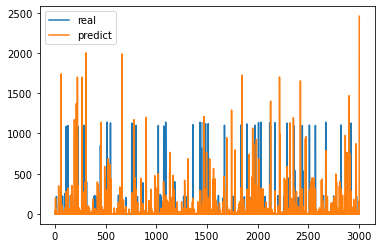

Epoch: 9; Test MAE loss on source data is: 45.826


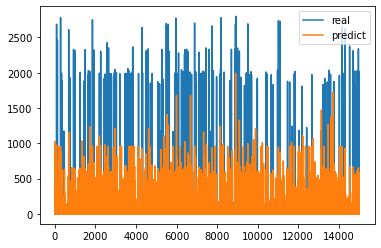

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


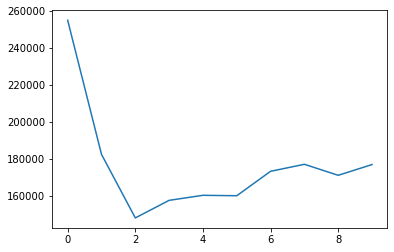

-------------------------- total running losses in 10 epoches as follows---------------------------------


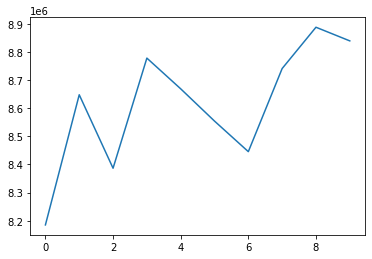

Epoch: 10; MSE loss: 9738151.249
Epoch: 10; disc loss: 165472.152
37.92797200883959
25474.652889803765
Parameter containing:
tensor([0.0499, 0.3838, 0.2453, 0.2220, 0.0989], device='cuda:0',
       requires_grad=True)
Epoch: 11; MSE loss: 9267566.405
Epoch: 11; disc loss: 146423.525
34.04232417402522
22233.46386322333
Parameter containing:
tensor([0.0223, 0.4227, 0.2468, 0.2249, 0.0833], device='cuda:0',
       requires_grad=True)
Epoch: 12; MSE loss: 9151211.097
Epoch: 12; disc loss: 154848.221
40.66750482058907
28474.86951311592
Parameter containing:
tensor([0.0200, 0.4545, 0.2406, 0.2229, 0.0619], device='cuda:0',
       requires_grad=True)
Epoch: 13; MSE loss: 8887852.493
Epoch: 13; disc loss: 148939.028
38.740468114364816
26234.208364228078
Parameter containing:
tensor([0.0200, 0.4779, 0.2387, 0.2223, 0.0411], device='cuda:0',
       requires_grad=True)
Epoch: 14; MSE loss: 9736373.227
Epoch: 14; disc loss: 125306.310
37.359472640573856
25390.120677311494
Parameter containing:
ten

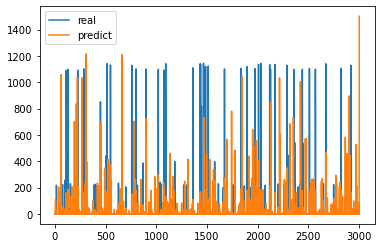

Epoch: 19; Test MAE loss on source data is: 35.056


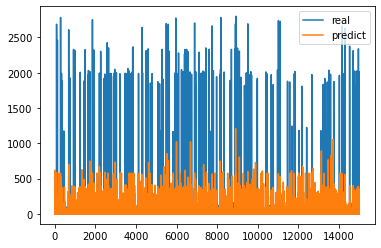

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


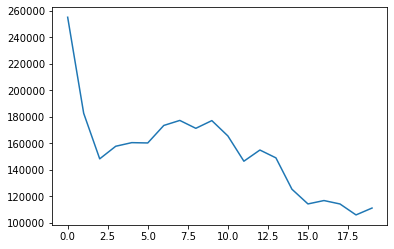

-------------------------- total running losses in 10 epoches as follows---------------------------------


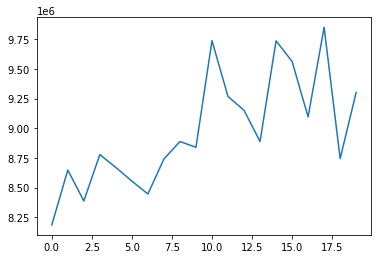

Epoch: 20; MSE loss: 9077344.992
Epoch: 20; disc loss: 114154.789
42.010132273064684
30647.426557861927
Parameter containing:
tensor([0.0200, 0.7306, 0.1237, 0.1057, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 21; MSE loss: 9588880.352
Epoch: 21; disc loss: 96293.315
45.4873168748674
35820.56153130019
Parameter containing:
tensor([0.0200, 0.7920, 0.0902, 0.0777, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 22; MSE loss: 9228597.444
Epoch: 22; disc loss: 84502.418
34.11519876922428
22141.722707265977
Parameter containing:
tensor([0.0200, 0.8516, 0.0571, 0.0512, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 23; MSE loss: 9034677.297
Epoch: 23; disc loss: 57850.594
35.84184230041441
23310.64895359773
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 24; MSE loss: 7981775.568
Epoch: 24; disc loss: 53911.972
37.75559198060162
26071.039505636487
Parameter containing:
tensor([0

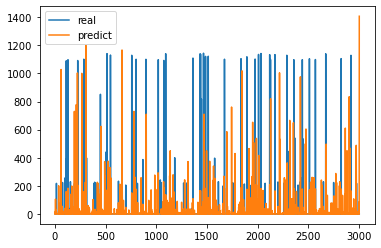

Epoch: 29; Test MAE loss on source data is: 35.315


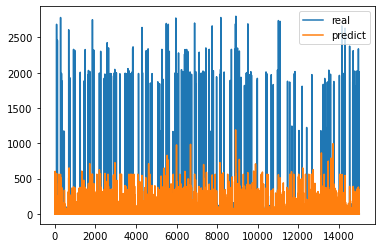

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


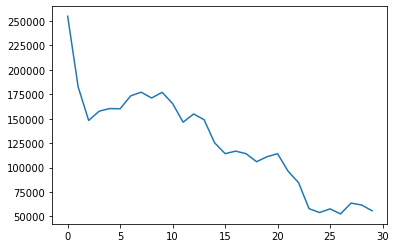

-------------------------- total running losses in 10 epoches as follows---------------------------------


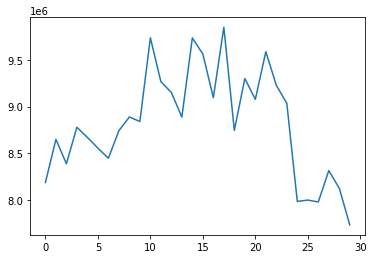

Epoch: 30; MSE loss: 8249158.991
Epoch: 30; disc loss: 63283.596
49.66469441676042
41521.99290031625
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 31; MSE loss: 8905849.620
Epoch: 31; disc loss: 52865.778
39.829623706087794
27430.986029282907
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 32; MSE loss: 7912843.343
Epoch: 32; disc loss: 51966.752
40.61174016833368
28605.918510484145
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 33; MSE loss: 8718309.371
Epoch: 33; disc loss: 42672.563
36.487024566370295
23860.25941402491
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 34; MSE loss: 8762917.238
Epoch: 34; disc loss: 47339.294
25.994817939814705
17212.239614872284
Parameter containing:
tensor(

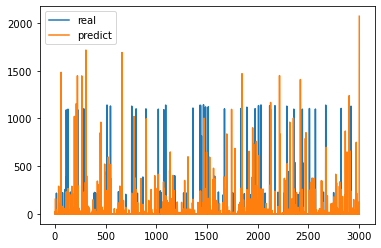

Epoch: 39; Test MAE loss on source data is: 40.629


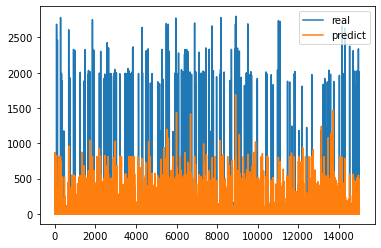

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


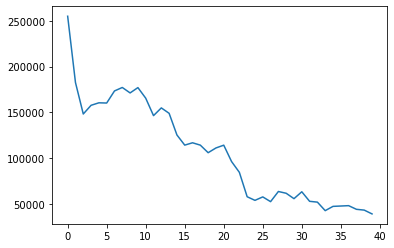

-------------------------- total running losses in 10 epoches as follows---------------------------------


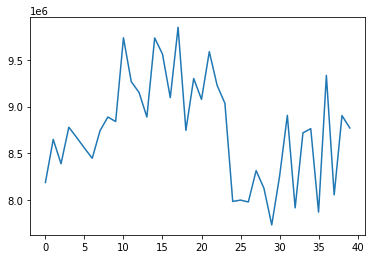

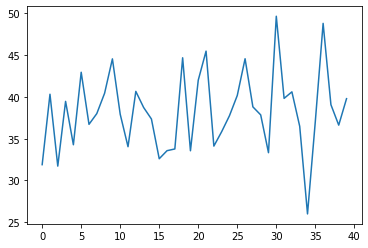

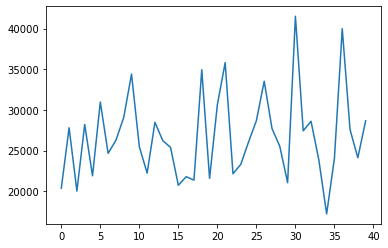

39.794409500780574
0.4450515443952333
1.2872006572497368
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)

---------------------------------------------- domain num 2 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 9626638.000
25.73599217609737
48716.39200727933
Epoch: 1; MSE loss: 9334345.000
27.46750860666849
45242.83572772331
Epoch: 2; MSE loss: 8340376.000
28.525519418883597
43545.74539139536
Epoch: 3; MSE loss: 8496330.000
33.966337809549984
37067.126003861486
Epoch: 4; MSE loss: 8295563.500
31.415769894299817
38595.46155479981
Epoch: 5; MSE loss: 7650815.000
33.9825646795888
35454.43780861362
Epoch: 6; MSE loss: 7774228.500
37.08279911527155
33317.03307518808
Epoch: 7; MSE loss: 7326706.000
31.209144273775316
35498.20779275154
Epoch: 8; MSE loss: 6954882.500
31.56180123116985
35396.736842555096
Epoch: 9; MSE loss: 7359923.000
31.8552472776747
34200.02548611295
E

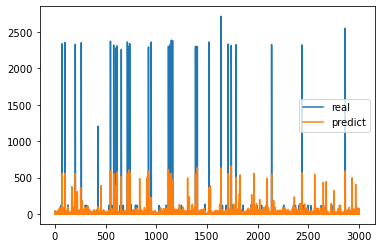

Epoch: 10; Test MAE loss on source data is: 36.972
Epoch: 10; Test MSE loss on source data is: 32156.917


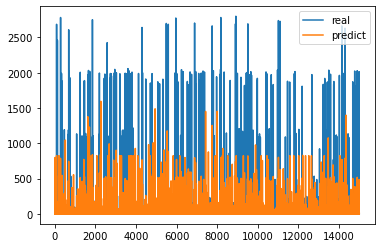

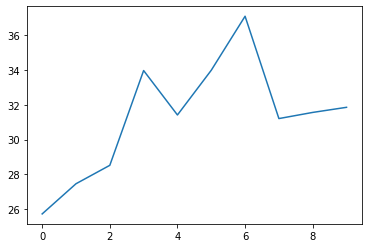

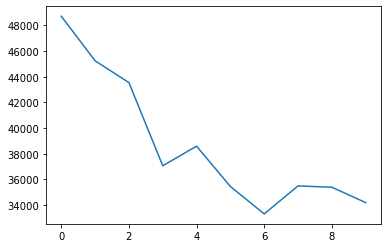

------------Domain Adaptation------------
Epoch: 0; MSE loss: 9411856.681
Epoch: 0; disc loss: 120349.302
35.03521154833816
51615.96704061651
Parameter containing:
tensor([0.2003, 0.1979, 0.1989, 0.2027, 0.2002], device='cuda:0',
       requires_grad=True)
Epoch: 1; MSE loss: 9881281.369
Epoch: 1; disc loss: 51699.812
35.54452048099231
52420.56955779413
Parameter containing:
tensor([0.1983, 0.2000, 0.1875, 0.2001, 0.2141], device='cuda:0',
       requires_grad=True)
Epoch: 2; MSE loss: 9934925.651
Epoch: 2; disc loss: 110571.172
36.45489234985231
52252.07645806323
Parameter containing:
tensor([0.1950, 0.2062, 0.1776, 0.2020, 0.2192], device='cuda:0',
       requires_grad=True)
Epoch: 3; MSE loss: 10092645.875
Epoch: 3; disc loss: 191553.701
35.599543949705705
52281.38441411296
Parameter containing:
tensor([0.1959, 0.2150, 0.1670, 0.2065, 0.2156], device='cuda:0',
       requires_grad=True)
Epoch: 4; MSE loss: 10278849.270
Epoch: 4; disc loss: 261609.445
34.78132071463855
52283.50257085

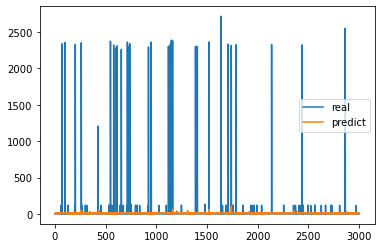

Epoch: 9; Test MAE loss on source data is: 33.801


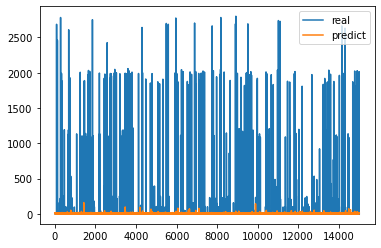

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


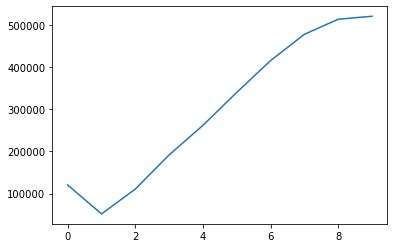

-------------------------- total running losses in 10 epoches as follows---------------------------------


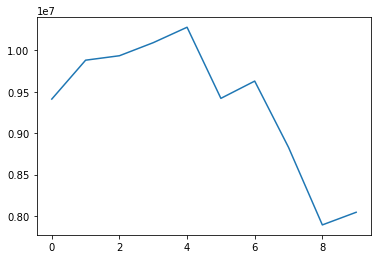

Epoch: 10; MSE loss: 7914507.546
Epoch: 10; disc loss: 498462.464
34.96093164664878
52301.9675259996
Parameter containing:
tensor([0.2109, 0.2992, 0.0200, 0.2577, 0.2122], device='cuda:0',
       requires_grad=True)
Epoch: 11; MSE loss: 7134160.139
Epoch: 11; disc loss: 481299.066
36.02402072196477
52369.85036100584
Parameter containing:
tensor([0.2035, 0.3086, 0.0200, 0.2585, 0.2093], device='cuda:0',
       requires_grad=True)
Epoch: 12; MSE loss: 7656548.337
Epoch: 12; disc loss: 518316.405
35.32344240138553
52129.76204256122
Parameter containing:
tensor([0.1978, 0.3198, 0.0200, 0.2603, 0.2022], device='cuda:0',
       requires_grad=True)
Epoch: 13; MSE loss: 7135793.184
Epoch: 13; disc loss: 519669.585
35.562576107958584
52402.08866555689
Parameter containing:
tensor([0.1900, 0.3330, 0.0200, 0.2617, 0.1953], device='cuda:0',
       requires_grad=True)
Epoch: 14; MSE loss: 7286933.149
Epoch: 14; disc loss: 556348.638
33.564020804723555
52106.02280228549
Parameter containing:
tensor(

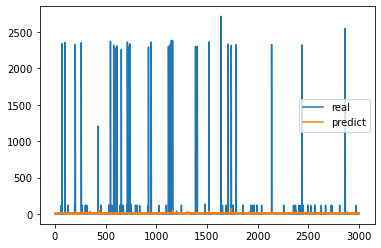

Epoch: 19; Test MAE loss on source data is: 35.006


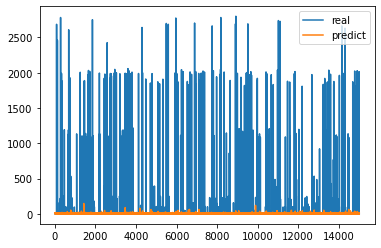

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


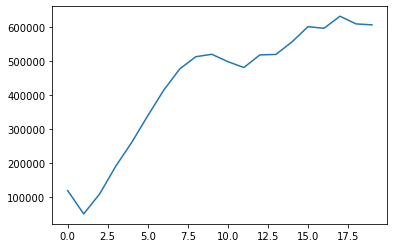

-------------------------- total running losses in 10 epoches as follows---------------------------------


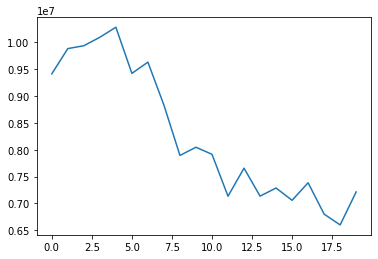

Epoch: 20; MSE loss: 7210332.882
Epoch: 20; disc loss: 617978.989
35.18976387499364
52348.93484351427
Parameter containing:
tensor([0.0730, 0.5076, 0.0200, 0.2923, 0.1071], device='cuda:0',
       requires_grad=True)
Epoch: 21; MSE loss: 6223230.158
Epoch: 21; disc loss: 616796.081
34.23363177325532
52445.97381939102
Parameter containing:
tensor([0.0483, 0.5460, 0.0200, 0.3012, 0.0845], device='cuda:0',
       requires_grad=True)
Epoch: 22; MSE loss: 6221945.764
Epoch: 22; disc loss: 576971.216
35.075755403951284
52304.7683257115
Parameter containing:
tensor([0.0200, 0.5950, 0.0200, 0.3082, 0.0568], device='cuda:0',
       requires_grad=True)
Epoch: 23; MSE loss: 5682445.041
Epoch: 23; disc loss: 520714.921
35.77622631526789
52327.14062192867
Parameter containing:
tensor([0.0200, 0.6324, 0.0200, 0.3057, 0.0218], device='cuda:0',
       requires_grad=True)
Epoch: 24; MSE loss: 5585547.260
Epoch: 24; disc loss: 491010.485
33.28797696038743
52108.872940220885
Parameter containing:
tensor(

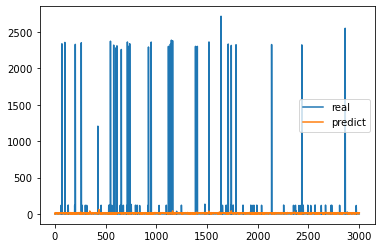

Epoch: 29; Test MAE loss on source data is: 36.215


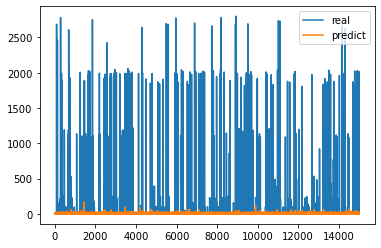

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


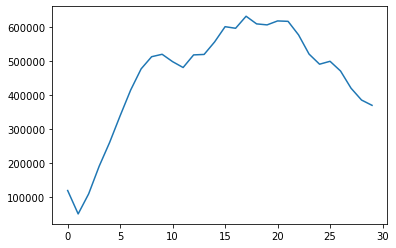

-------------------------- total running losses in 10 epoches as follows---------------------------------


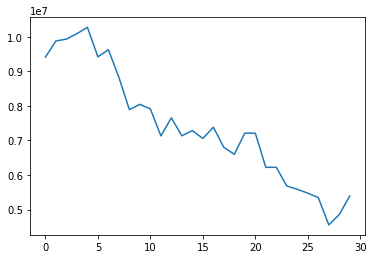

Epoch: 30; MSE loss: 4384725.837
Epoch: 30; disc loss: 358358.695
34.879996269916525
52328.05827117879
Parameter containing:
tensor([0.0200, 0.7599, 0.0200, 0.1800, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 31; MSE loss: 4692262.794
Epoch: 31; disc loss: 317330.629
36.761436821059505
52398.0720635869
Parameter containing:
tensor([0.0200, 0.7898, 0.0200, 0.1502, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 32; MSE loss: 4588251.675
Epoch: 32; disc loss: 298467.028
33.64161835099197
52324.98153805328
Parameter containing:
tensor([0.0200, 0.8222, 0.0200, 0.1178, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 33; MSE loss: 4092259.481
Epoch: 33; disc loss: 261725.949
33.66312374597472
52469.989796037975
Parameter containing:
tensor([0.0200, 0.8571, 0.0200, 0.0829, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 34; MSE loss: 3679336.717
Epoch: 34; disc loss: 228675.591
36.19594021307208
52362.048591265586
Parameter containing:
tenso

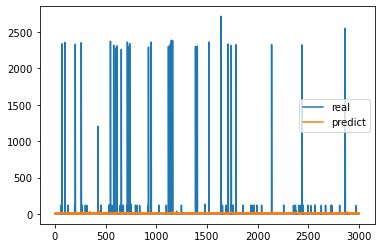

Epoch: 39; Test MAE loss on source data is: 33.911


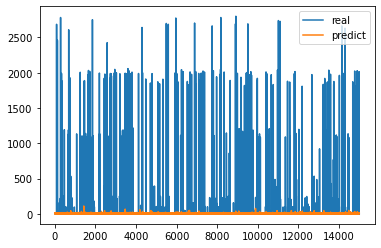

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


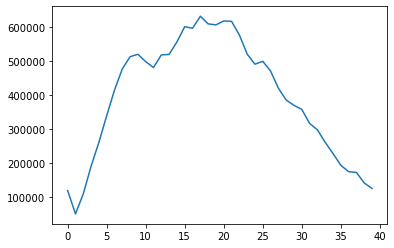

-------------------------- total running losses in 10 epoches as follows---------------------------------


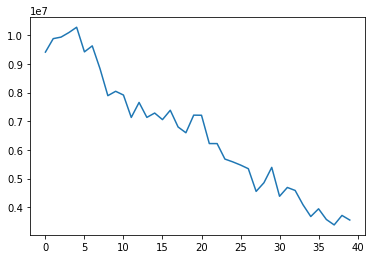

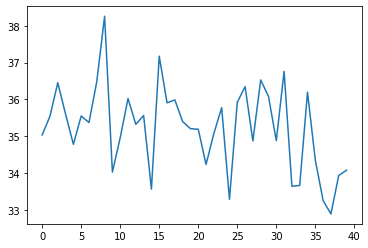

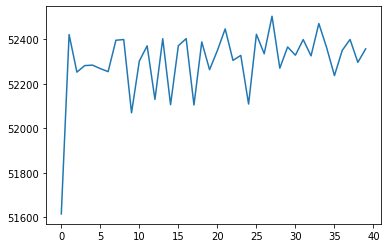

34.0764114076542
0.5903244950592413
0.9994975040621863
Parameter containing:
tensor([0.0200, 0.9200, 0.0200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)

---------------------------------------------- domain num 4 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 9867795.000
25.95372630319572
30280.261128468857
Epoch: 1; MSE loss: 9001171.000
28.789361669705528
29364.78886796054
Epoch: 2; MSE loss: 8387989.000
36.38372011818041
28757.14361215593
Epoch: 3; MSE loss: 8267501.000
40.08139674585764
28694.96516290387
Epoch: 4; MSE loss: 8205180.000
47.95310806740229
30185.587104826507
Epoch: 5; MSE loss: 8186341.000
44.52365730113577
29394.154037052213
Epoch: 6; MSE loss: 7487683.500
65.53000024476209
38975.71784952951
Epoch: 7; MSE loss: 7438406.000
50.598210938297186
31890.470853493476
Epoch: 8; MSE loss: 7846786.000
55.99376167531079
34601.80689269048
Epoch: 9; MSE loss: 7024844.500
48.89850409418474
31381.64724378506
E

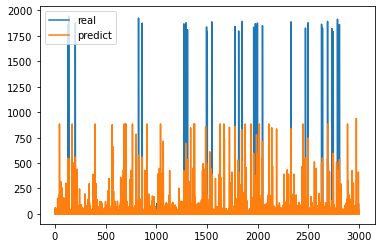

Epoch: 10; Test MAE loss on source data is: 31.190
Epoch: 10; Test MSE loss on source data is: 29003.076


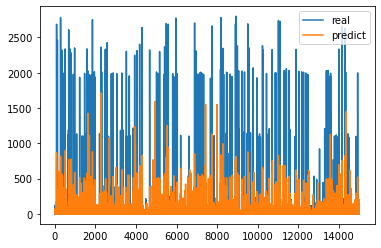

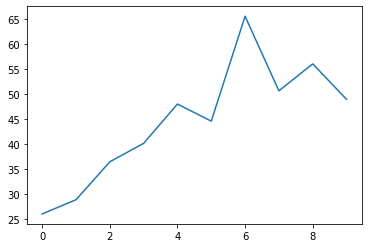

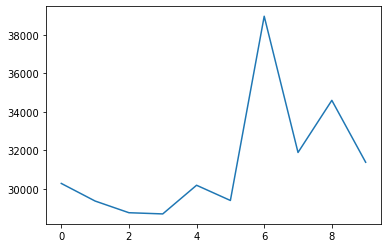

------------Domain Adaptation------------
Epoch: 0; MSE loss: 7202958.363
Epoch: 0; disc loss: 323381.535
58.60958817484509
36072.62644456923
Parameter containing:
tensor([0.1996, 0.1953, 0.2015, 0.2030, 0.2006], device='cuda:0',
       requires_grad=True)
Epoch: 1; MSE loss: 7911903.713
Epoch: 1; disc loss: 200684.531
56.80472620543261
35040.372022679905
Parameter containing:
tensor([0.1980, 0.1787, 0.2058, 0.2210, 0.1966], device='cuda:0',
       requires_grad=True)
Epoch: 2; MSE loss: 7628523.074
Epoch: 2; disc loss: 158637.106
78.51975641090091
52163.60324734586
Parameter containing:
tensor([0.1885, 0.1566, 0.2086, 0.2527, 0.1935], device='cuda:0',
       requires_grad=True)
Epoch: 3; MSE loss: 7797375.604
Epoch: 3; disc loss: 136981.947
51.09067873837806
32737.81992020855
Parameter containing:
tensor([0.1814, 0.1322, 0.2221, 0.2662, 0.1981], device='cuda:0',
       requires_grad=True)
Epoch: 4; MSE loss: 8019183.155
Epoch: 4; disc loss: 129469.856
43.9521382489228
30315.1422891195

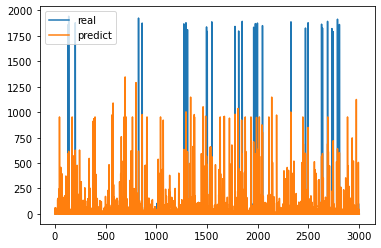

Epoch: 9; Test MAE loss on source data is: 33.835


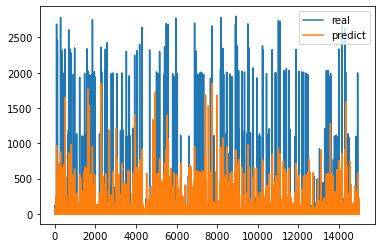

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


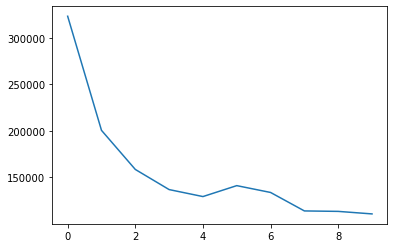

-------------------------- total running losses in 10 epoches as follows---------------------------------


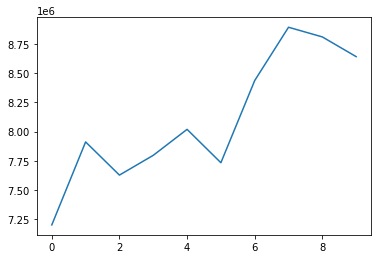

Epoch: 10; MSE loss: 8198015.506
Epoch: 10; disc loss: 100757.616
88.60243178404541
64372.07474710814
Parameter containing:
tensor([0.1230, 0.0200, 0.4196, 0.1567, 0.2806], device='cuda:0',
       requires_grad=True)
Epoch: 11; MSE loss: 8812386.071
Epoch: 11; disc loss: 93515.433
50.20998119512702
32230.746288374055
Parameter containing:
tensor([0.1011, 0.0200, 0.4561, 0.1317, 0.2911], device='cuda:0',
       requires_grad=True)
Epoch: 12; MSE loss: 8551954.345
Epoch: 12; disc loss: 97730.939
62.15500400519462
40150.96721534097
Parameter containing:
tensor([0.0785, 0.0200, 0.4891, 0.1056, 0.3068], device='cuda:0',
       requires_grad=True)
Epoch: 13; MSE loss: 8873863.200
Epoch: 13; disc loss: 88051.991
45.37035495732302
30409.47383680023
Parameter containing:
tensor([0.0507, 0.0200, 0.5382, 0.0732, 0.3180], device='cuda:0',
       requires_grad=True)
Epoch: 14; MSE loss: 7846013.950
Epoch: 14; disc loss: 69840.858
58.268129293255
37426.64586380906
Parameter containing:
tensor([0.020

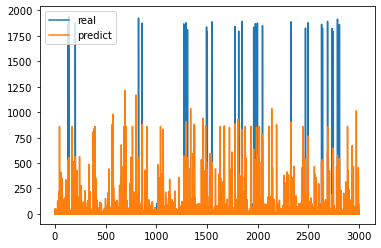

Epoch: 19; Test MAE loss on source data is: 32.071


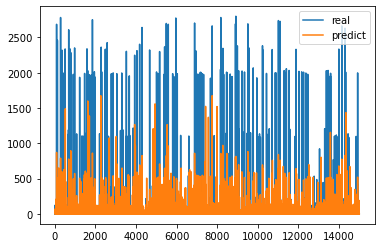

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


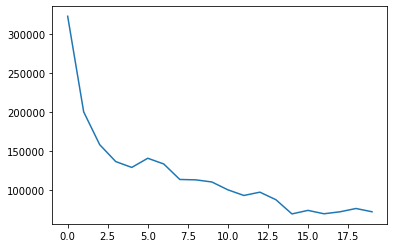

-------------------------- total running losses in 10 epoches as follows---------------------------------


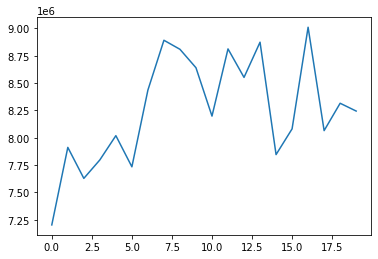

Epoch: 20; MSE loss: 8570932.375
Epoch: 20; disc loss: 69383.584
65.99192536399315
42657.21873234939
Parameter containing:
tensor([0.0200, 0.0200, 0.7055, 0.0200, 0.2345], device='cuda:0',
       requires_grad=True)
Epoch: 21; MSE loss: 8582758.381
Epoch: 21; disc loss: 72132.082
50.18447689415413
32384.423177639612
Parameter containing:
tensor([0.0200, 0.0200, 0.7249, 0.0200, 0.2151], device='cuda:0',
       requires_grad=True)
Epoch: 22; MSE loss: 8176099.200
Epoch: 22; disc loss: 69917.506
64.1983071434412
40299.93592433896
Parameter containing:
tensor([0.0200, 0.0200, 0.7419, 0.0200, 0.1981], device='cuda:0',
       requires_grad=True)
Epoch: 23; MSE loss: 7808276.026
Epoch: 23; disc loss: 78001.415
50.3013767490409
32220.897513992815
Parameter containing:
tensor([0.0200, 0.0200, 0.7558, 0.0200, 0.1842], device='cuda:0',
       requires_grad=True)
Epoch: 24; MSE loss: 8104718.809
Epoch: 24; disc loss: 75035.604
71.55569409182948
45961.67851128626
Parameter containing:
tensor([0.020

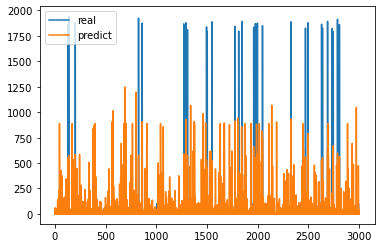

Epoch: 29; Test MAE loss on source data is: 33.396


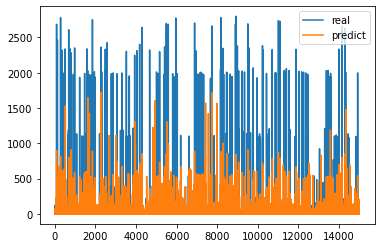

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


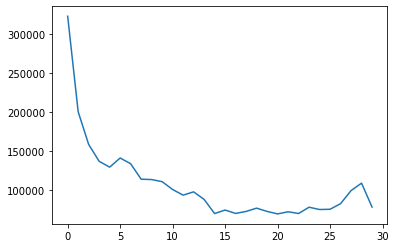

-------------------------- total running losses in 10 epoches as follows---------------------------------


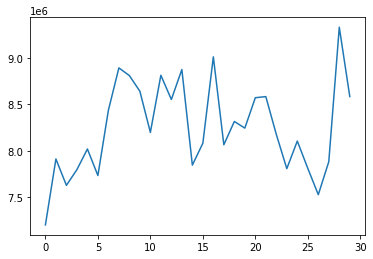

Epoch: 30; MSE loss: 8415078.093
Epoch: 30; disc loss: 63104.833
50.057461350233595
33040.765917160374
Parameter containing:
tensor([0.0200, 0.0200, 0.9172, 0.0200, 0.0228], device='cuda:0',
       requires_grad=True)
Epoch: 31; MSE loss: 8905212.575
Epoch: 31; disc loss: 55282.312
54.657517308790915
34972.713000923475
Parameter containing:
tensor([0.0200, 0.0200, 0.9200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 32; MSE loss: 7454735.171
Epoch: 32; disc loss: 61432.529
75.95423439272447
50101.93578431834
Parameter containing:
tensor([0.0200, 0.0200, 0.9200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 33; MSE loss: 7991828.274
Epoch: 33; disc loss: 81797.627
51.134054347208036
32943.26293330572
Parameter containing:
tensor([0.0200, 0.0200, 0.9200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)
Epoch: 34; MSE loss: 8690364.026
Epoch: 34; disc loss: 93237.978
50.78617587504281
31866.94406049782
Parameter containing:
tensor([

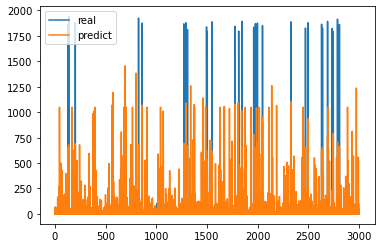

Epoch: 39; Test MAE loss on source data is: 34.771


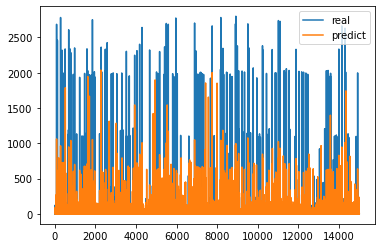

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


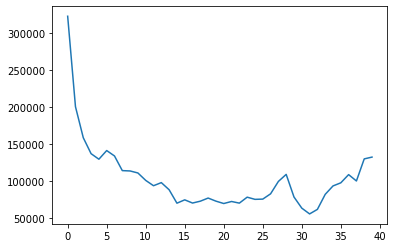

-------------------------- total running losses in 10 epoches as follows---------------------------------


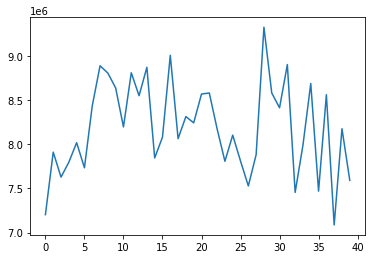

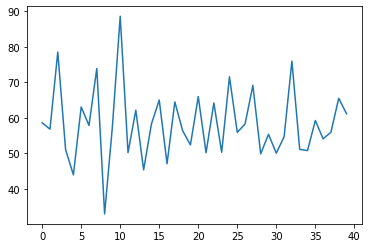

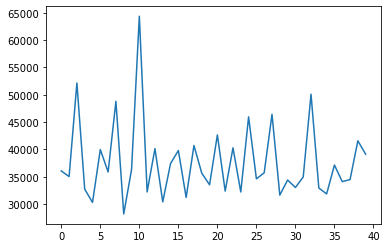

61.1642959140447
2.1022297896028355
1.0824273567095226
Parameter containing:
tensor([0.0200, 0.0200, 0.9200, 0.0200, 0.0200], device='cuda:0',
       requires_grad=True)


In [12]:
import importlib
# import models.hdisc_msda 
# importlib.reload(models.hdisc_msda)
# from models.hdisc_msda import Disc_MSDANet
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =10,40

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in [0,2,4]:
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.0001
        lr1=0.00001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
#         lr = 0.0001
#         lr1=0.000001
#         batch_size =64
#         b1=0.99
#         b2=0.999
# #         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
# #         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
#         opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
#         opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
#         opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
#         opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
#         opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
#         opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
#         model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(5):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
                for c in range(1):
                    loss0=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(2):
                    alpha_loss0=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)

In [13]:
# ######################################microwave###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# # trainfile2="/content/drive/MyDrive/training_data/microwave_house_3_training_.csv"

# # trainfile1="/content/drive/MyDrive/ukdale_training/microwave_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile4="/content/drive/MyDrive/refit_training/microwave/microwave_house_10_training_.csv"
# trainfile3="/content/drive/MyDrive/refit_training/microwave/microwave_house_17_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[16,2,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=200
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

In [11]:
#  ######################################microwave###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="training_data/microwave_house_3_training_.csv"

# trainfile2="ukdale_training/microwave_house_1_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="refit_training/microwave/microwave_house_10_training_.csv"
# trainfile4="refit_training/microwave/microwave_house_17_training_.csv"

# # fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# # stepsizeList=[2,16,16,16]
# # data_insts, data_labels, num_insts,on = [], [], [],[]
# # threshold=200
# # for i in range(len(fileList)):
# #     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
# #     Y=Y.reshape(-1,1)
# #     data_insts.append(X)
# #     data_labels.append(Y)
# #     num_insts.append(X.shape[0])
# # min_size=min(num_insts)
# # x_tem, y_tem=[],[]
# # for j in range(len(fileList)):
# #   ridx = np.random.choice(num_insts[j], min_size)
# #   x_tem.append(data_insts[j][ridx, :])
# #   y_tem.append(data_labels[j][ridx, :])
# #   num_insts[j]=x_tem[j].shape[0]
# # data_insts=x_tem
# # data_labels=y_tem 
# # print(num_insts)

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=200
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     X_on=X[Y>0]
#     Y_on=Y[Y>0]
#     X_off=X[Y==0]
#     Y_off=Y[Y==0]
#     ridx = np.random.choice(X_off.shape[0], int(len(Y_on)*50))
#     X_off = X_off[ridx, :]
#     Y_on=Y_on.reshape(-1,1)
#     Y_off=Y_off.reshape(-1,1)
#     Y_off = Y_off[ridx, :]
#     X_pre=np.concatenate([X_on,X_off], axis=0)
#     Y_pre=np.concatenate([Y_on,Y_off], axis=0)
#     on.append(Y_on)
#     data_insts.append(X_pre)
#     data_labels.append(Y_pre)
#     num_insts.append(X_pre.shape[0])
#     # r_order = np.arange(num_insts[i])
#     # np.random.shuffle(r_order)
#     # data_insts[i] = data_insts[i][r_order, :]
#     # data_labels[i] = data_labels[i][r_order,:]
# print(num_insts)
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)


trainfile1="F:/NILM/training_data/microwave_test_.csv"
trainfile2="F:/NILM/training_data/microwave_house_2_training_.csv"
trainfile3="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
trainfile4="F:/NILM/ukdale_training/microwave_house_2_training_.csv"
trainfile5="F:/NILM/refit_training/microwave/microwave_house_10_training_.csv"
trainfile6="F:/NILM/refit_training/microwave/microwave_house_17_training_.csv"
fileList=[trainfile1,trainfile2,trainfile3,trainfile4,trainfile5,trainfile6]
stepsizeList=[2,1,16,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=200
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    X_on=X[Y>0]
    Y_on=Y[Y>0]
    X_off=X[Y==0]
    Y_off=Y[Y==0]
    ridx = np.random.choice(X_off.shape[0], int(len(Y_on)*50))
    X_off = X_off[ridx, :]
    Y_on=Y_on.reshape(-1,1)
    Y_off=Y_off.reshape(-1,1)
    Y_off = Y_off[ridx, :]
    X_pre=np.concatenate([X_on,X_off], axis=0)
    Y_pre=np.concatenate([Y_on,Y_off], axis=0)
    on.append(Y_on)
    data_insts.append(X_pre)
    data_labels.append(Y_pre)
    num_insts.append(X_pre.shape[0])
    # r_order = np.arange(num_insts[i])
    # np.random.shuffle(r_order)
    # data_insts[i] = data_insts[i][r_order, :]
    # data_labels[i] = data_labels[i][r_order,:]
print(num_insts)
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[13311, 5508, 51816, 4335, 11475, 10302]
[4335, 4335, 4335, 4335, 4335, 4335]



 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 5 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 2323261.000
38.21582841905824
46861.86582057991
Epoch: 1; MSE loss: 2487276.500
38.763420796879025
46095.49100052709
Epoch: 2; MSE loss: 2319794.250
38.78359315485931
45918.04861513217
Epoch: 3; MSE loss: 2369458.000
39.894439353267074
45150.88874758407
Epoch: 4; MSE loss: 2373989.250
40.29313501267078
44817.03967500212
Epoch: 5; MSE loss: 2284229.750
41.44206530681565
43890.221149681194
Epoch: 6; MSE loss: 2196837.500
42.16310128342734
43287.99807515194
Epoch: 7; MSE loss: 2126576.250
42.03969771952949
43444.883568176054
Epoch: 8; MSE loss: 2035710.000
43.22624405379801
42970.25389002405
Epoch: 9; MSE loss: 2205360.750
44.329634221075175
42154.64292464179
Epoch: 10; Test MAE loss on target data is: 44.330
Epoch: 10; Test MSE loss on target data is: 42154.643

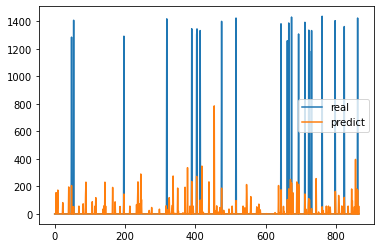

Epoch: 10; Test MAE loss on source data is: 33.005
Epoch: 10; Test MSE loss on source data is: 35313.710


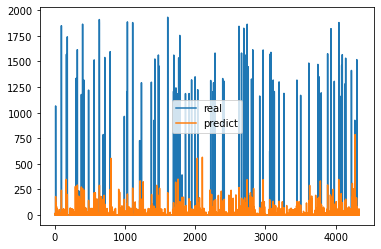

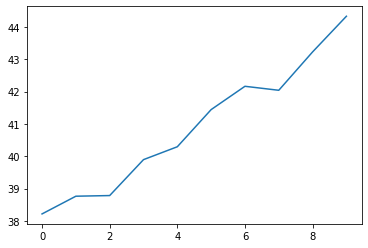

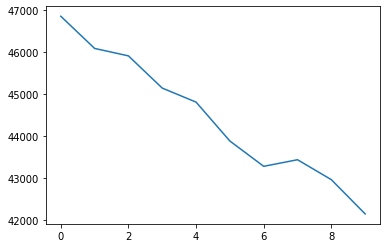

------------Domain Adaptation------------
Epoch: 0; MSE loss: 1092484.039
Epoch: 0; disc loss: 2323.815
46.313958461378135
41629.49138349765
Parameter containing:
tensor([0.2002, 0.2001, 0.1999, 0.2000, 0.1998], device='cuda:0',
       requires_grad=True)
Epoch: 1; MSE loss: 1099774.899
Epoch: 1; disc loss: 2276.750
46.583697673221224
41595.41007415978
Parameter containing:
tensor([0.2002, 0.2002, 0.1999, 0.2001, 0.1996], device='cuda:0',
       requires_grad=True)
Epoch: 2; MSE loss: 989283.283
Epoch: 2; disc loss: 2234.865
45.41208639904221
41932.47030093693
Parameter containing:
tensor([0.2002, 0.2003, 0.1999, 0.2001, 0.1995], device='cuda:0',
       requires_grad=True)
Epoch: 3; MSE loss: 990626.236
Epoch: 3; disc loss: 2456.927
42.925484092315315
42982.573506180684
Parameter containing:
tensor([0.2001, 0.2002, 0.1999, 0.2001, 0.1996], device='cuda:0',
       requires_grad=True)
Epoch: 4; MSE loss: 997925.408
Epoch: 4; disc loss: 2835.855
46.2392193781429
41997.852994633264
Paramet

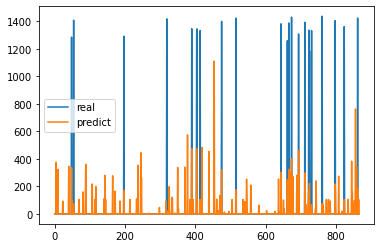

Epoch: 9; Test MAE loss on source data is: 35.889


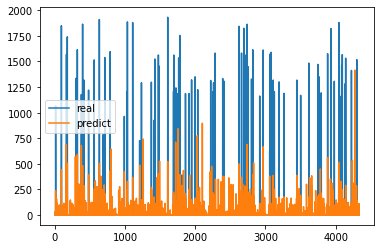

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


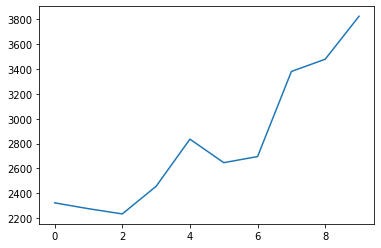

-------------------------- total running losses in 10 epoches as follows---------------------------------


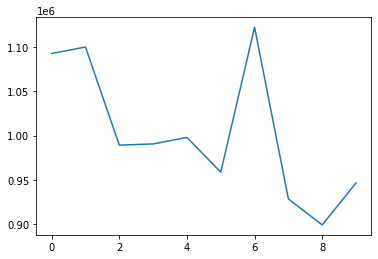

Epoch: 10; MSE loss: 980768.039
Epoch: 10; disc loss: 4264.717
47.019389227118594
40185.025969654576
Parameter containing:
tensor([0.1996, 0.1993, 0.2008, 0.2002, 0.2001], device='cuda:0',
       requires_grad=True)
Epoch: 11; MSE loss: 949769.583
Epoch: 11; disc loss: 4129.653
47.86726450062472
40086.122801805126
Parameter containing:
tensor([0.1994, 0.1991, 0.2010, 0.2002, 0.2003], device='cuda:0',
       requires_grad=True)
Epoch: 12; MSE loss: 968286.815
Epoch: 12; disc loss: 4092.760
45.58241306394854
40028.9321850387
Parameter containing:
tensor([0.1993, 0.1989, 0.2013, 0.2002, 0.2004], device='cuda:0',
       requires_grad=True)
Epoch: 13; MSE loss: 853248.025
Epoch: 13; disc loss: 7183.889
48.622279831832394
38922.109996138104
Parameter containing:
tensor([0.1992, 0.1987, 0.2015, 0.2001, 0.2005], device='cuda:0',
       requires_grad=True)
Epoch: 14; MSE loss: 941934.782
Epoch: 14; disc loss: 6314.860
46.876181585376926
39121.87568641104
Parameter containing:
tensor([0.1992, 0.

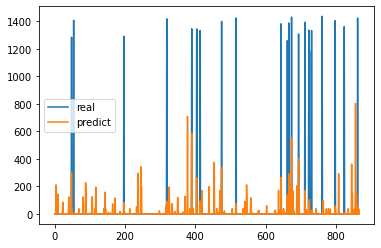

Epoch: 19; Test MAE loss on source data is: 31.135


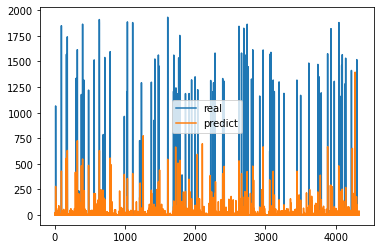

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


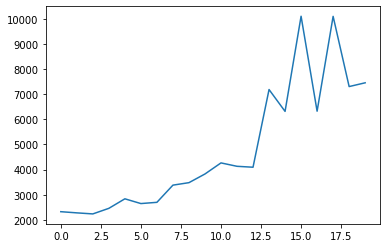

-------------------------- total running losses in 10 epoches as follows---------------------------------


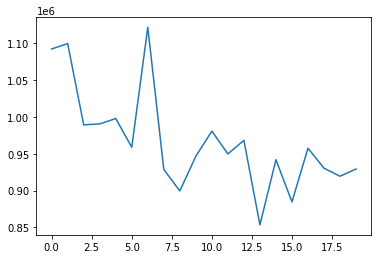

Epoch: 20; MSE loss: 921813.931
Epoch: 20; disc loss: 13737.199
51.22875570281567
39547.40028275474
Parameter containing:
tensor([0.1988, 0.1967, 0.2023, 0.2001, 0.2021], device='cuda:0',
       requires_grad=True)
Epoch: 21; MSE loss: 878299.956
Epoch: 21; disc loss: 6679.862
46.8708282670279
38056.842697059314
Parameter containing:
tensor([0.1987, 0.1963, 0.2024, 0.2002, 0.2024], device='cuda:0',
       requires_grad=True)
Epoch: 22; MSE loss: 837572.414
Epoch: 22; disc loss: 17512.114
44.28062453424298
38835.58431375786
Parameter containing:
tensor([0.1986, 0.1958, 0.2026, 0.2003, 0.2027], device='cuda:0',
       requires_grad=True)
Epoch: 23; MSE loss: 830671.465
Epoch: 23; disc loss: 8926.682
45.8774116414641
40698.01133985395
Parameter containing:
tensor([0.1985, 0.1952, 0.2028, 0.2004, 0.2031], device='cuda:0',
       requires_grad=True)
Epoch: 24; MSE loss: 955510.316
Epoch: 24; disc loss: 12355.208
44.86531093324757
40127.26445783121
Parameter containing:
tensor([0.1985, 0.194

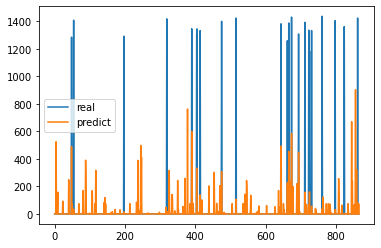

Epoch: 29; Test MAE loss on source data is: 32.425


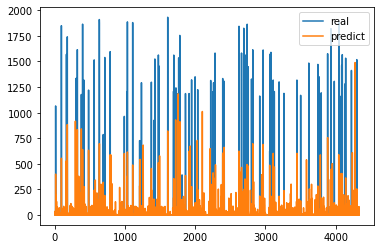

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


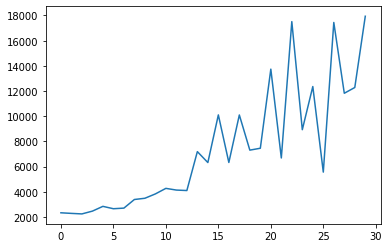

-------------------------- total running losses in 10 epoches as follows---------------------------------


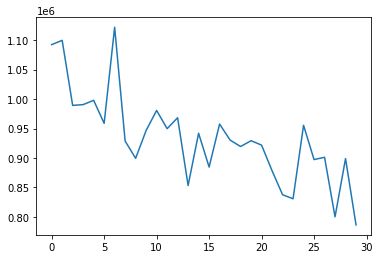

Epoch: 30; MSE loss: 753258.148
Epoch: 30; disc loss: 16858.804
48.64819869527974
42081.35229771216
Parameter containing:
tensor([0.1979, 0.1916, 0.2040, 0.2009, 0.2056], device='cuda:0',
       requires_grad=True)
Epoch: 31; MSE loss: 838155.532
Epoch: 31; disc loss: 13448.271
45.23387902204244
39479.57110725125
Parameter containing:
tensor([0.1977, 0.1913, 0.2041, 0.2008, 0.2061], device='cuda:0',
       requires_grad=True)
Epoch: 32; MSE loss: 757154.591
Epoch: 32; disc loss: 13858.020
46.25439167527145
41707.329799474894
Parameter containing:
tensor([0.1975, 0.1909, 0.2043, 0.2007, 0.2065], device='cuda:0',
       requires_grad=True)
Epoch: 33; MSE loss: 809932.075
Epoch: 33; disc loss: 18714.006
46.22051474972786
40125.614804786914
Parameter containing:
tensor([0.1973, 0.1906, 0.2045, 0.2006, 0.2070], device='cuda:0',
       requires_grad=True)
Epoch: 34; MSE loss: 795403.940
Epoch: 34; disc loss: 13369.696
45.33334486627352
42088.60457287737
Parameter containing:
tensor([0.1971, 

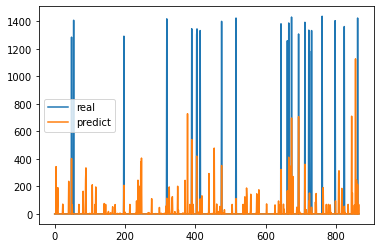

Epoch: 39; Test MAE loss on source data is: 31.243


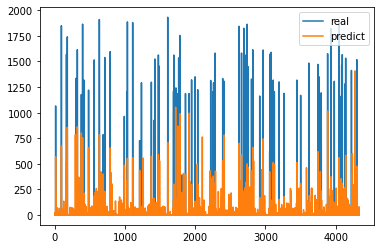

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


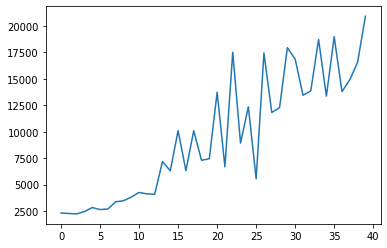

-------------------------- total running losses in 10 epoches as follows---------------------------------


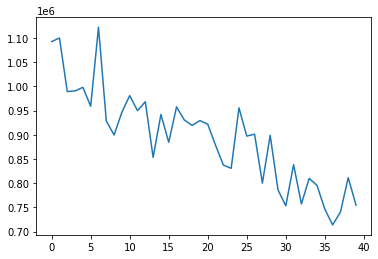

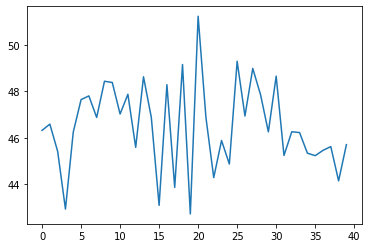

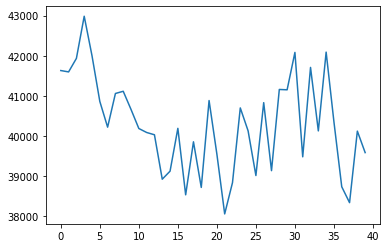

45.69900698494918
0.37217874987979227
0.8996504244363004
Parameter containing:
tensor([0.1952, 0.1894, 0.2058, 0.1995, 0.2101], device='cuda:0',
       requires_grad=True)


In [12]:
import importlib
# import models.hdisc_msda 
# importlib.reload(models.hdisc_msda)
# from models.hdisc_msda import Disc_MSDANet
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =10,40

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in [5]:
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.0001
        lr1=0.00001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
        lr = 0.0001
        lr1=0.000001
        batch_size =128
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(1):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
                for c in range(1):
                    loss0=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(1):
                    alpha_loss0=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)